# Import packages

In [1]:
import warnings
import scirpy as ir
warnings.simplefilter(action='ignore', category=FutureWarning)
from mousipy import translate
import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import muon as mu
%matplotlib inline
from glob import glob
import anndata
sc.set_figure_params(dpi=100)
import warnings
warnings.filterwarnings('ignore')
import scprep
from statannot import add_stat_annotation

2023-10-09 12:55:05.442809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-09 12:55:05.442834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from rpy2.robjects import pandas2ri
import anndata2ri

In [3]:
import rpy2.rinterface_lib.callbacks

In [4]:
import logging
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Import Object Concatenated

In [5]:
#adata_ = sc.read("/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/H5ad/Part1_raw_data_after_QC.h5ad")

In [6]:
adata = sc.read("/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/H5ad/Part2_Treg_outputDESC.h5ad")

# Cluster Tree

In [7]:
data_clus = adata.obs[['desc_0.2','desc_0.3','desc_0.4','desc_0.5','desc_0.6',
                       'desc_0.7','desc_0.8','desc_0.9','desc_1.0','desc_1.2']]

In [8]:
data_clus.columns = ['desc_r2_clusters','desc_r3_clusters', 'desc_r4_clusters','desc_r5_clusters', 'desc_r6_clusters', 'desc_r7_clusters', 'desc_r8_clusters','desc_r9_clusters','desc_r10_clusters','desc_r12_clusters']


In [9]:
data_clus.to_csv("/home/lugli/spuccio/Projects/Tmp/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/home/lugli/spuccio/Projects/Tmp/temp.csv",index_col=0,header=0)

In [10]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command

old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

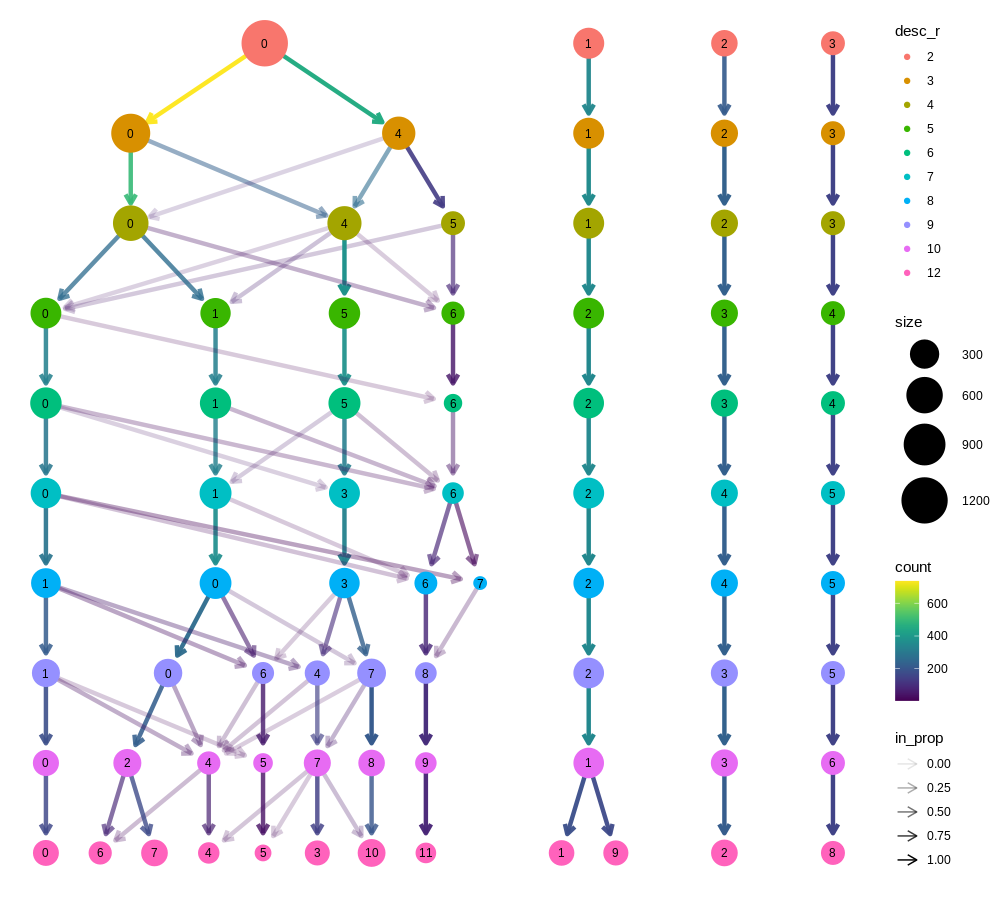

In [11]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="desc_r",suffix = "_clusters")

In [12]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb',n_neighbors=10, n_pcs=30)
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

# Resolution 2

In [13]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.2)]

In [14]:
run_vis(adata)

In [15]:
%matplotlib inline

### Resolution 2 Umap

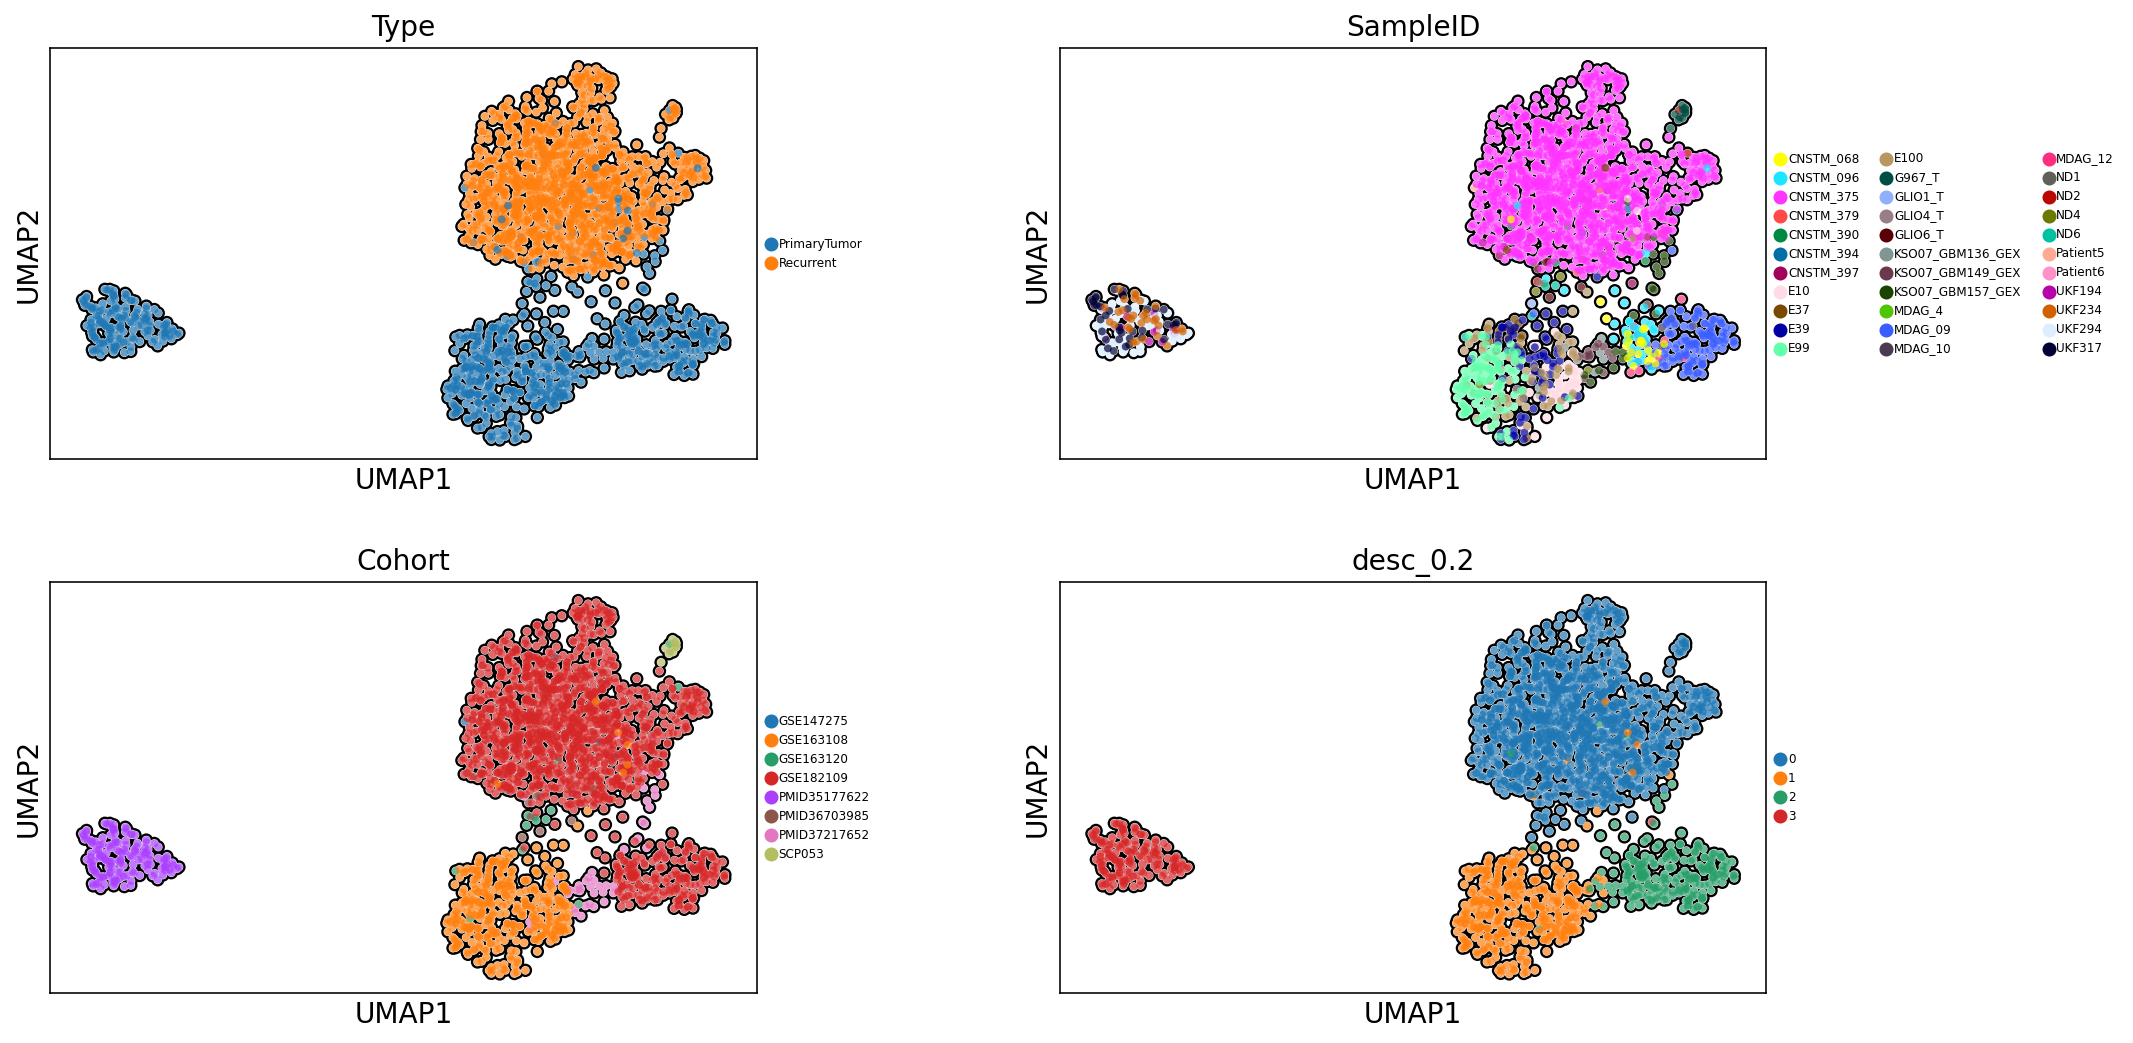

In [16]:
sc.pl.umap(adata, color=['Type','SampleID','Cohort','desc_0.2'],legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

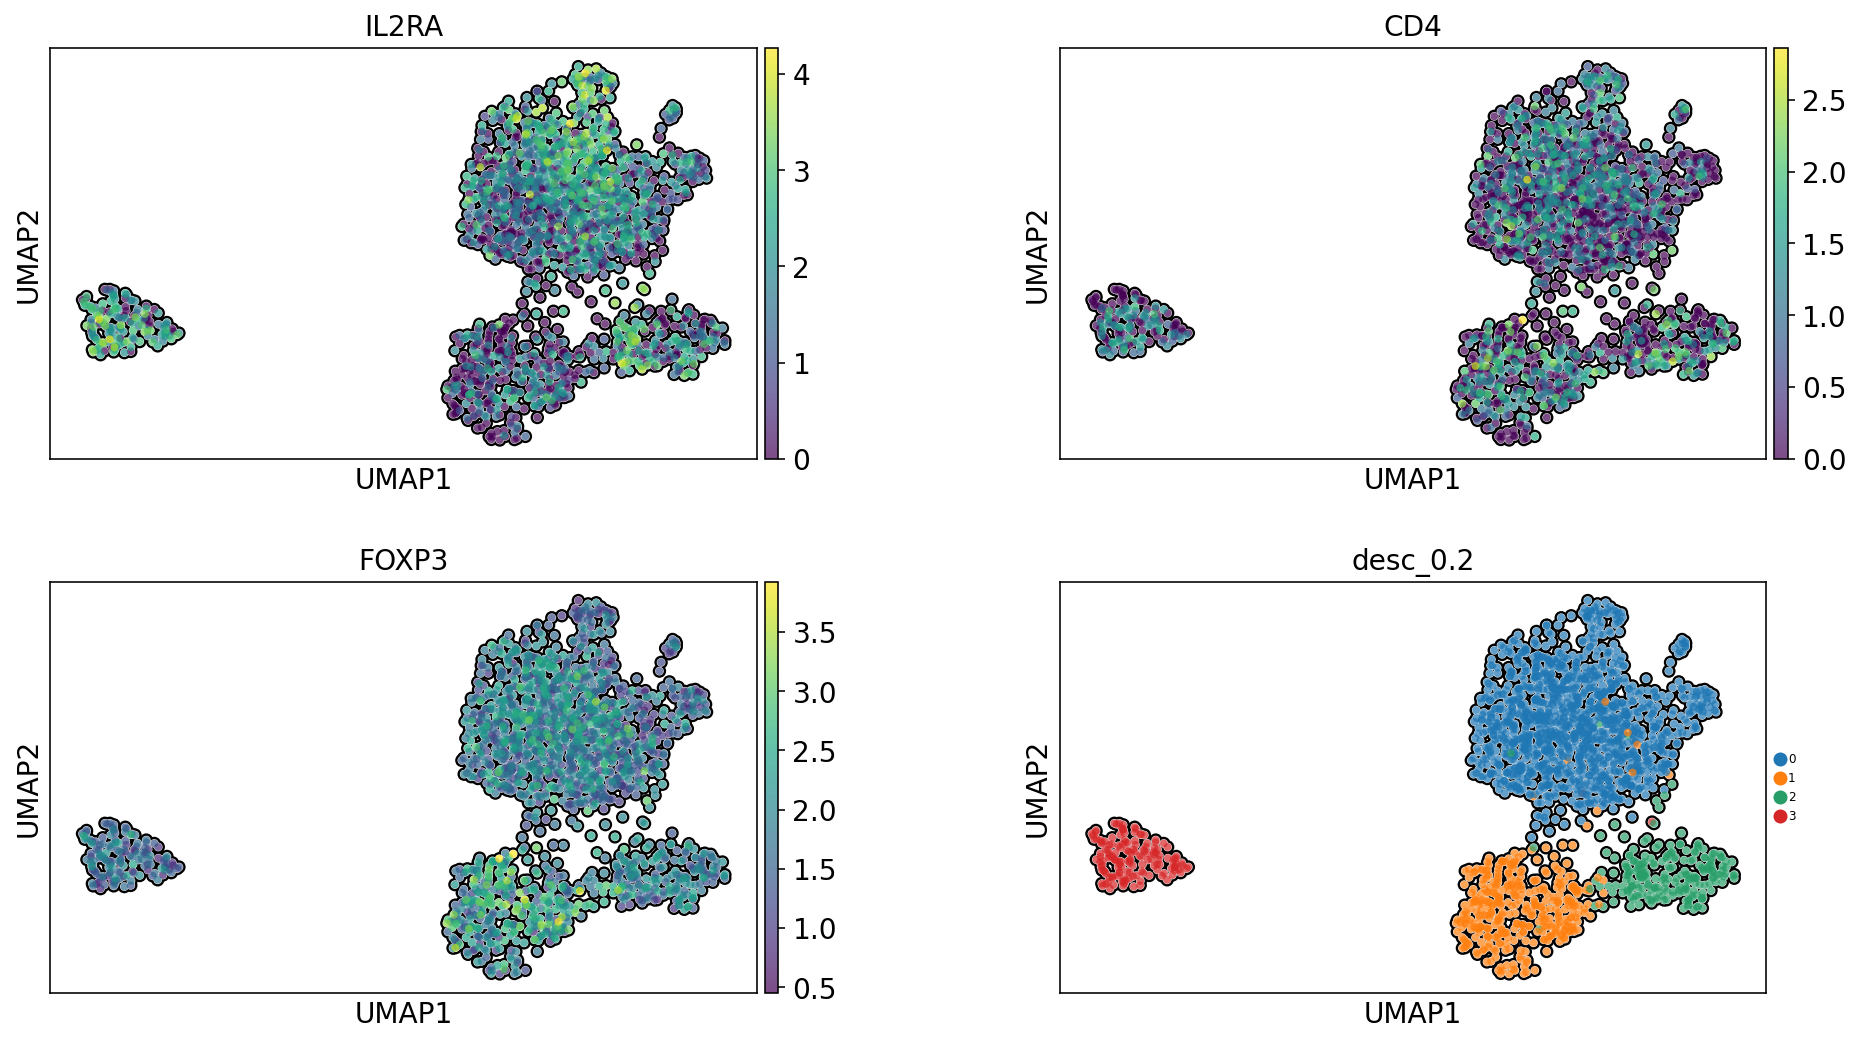

In [17]:
sc.pl.umap(adata, color=["IL2RA", "CD4", "FOXP3","desc_0.2"], legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

### Resolution 2 Cluster fraction for Type

In [18]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("desc_0.2")["Type"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("desc_0.2")["Type"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

### Resolution 2 Cluster Frequency for single Ptz

In [40]:
df = pd.DataFrame(adata.obs.groupby("desc_0.2")["Type","Sample"].value_counts(normalize=True))
df.to_csv("./test3.csv",sep="\t",header=True,index=True)
df2 = pd.read_csv("./test3.csv",sep="\t",header=0)
df2 = df2.loc[df2['0']>0]

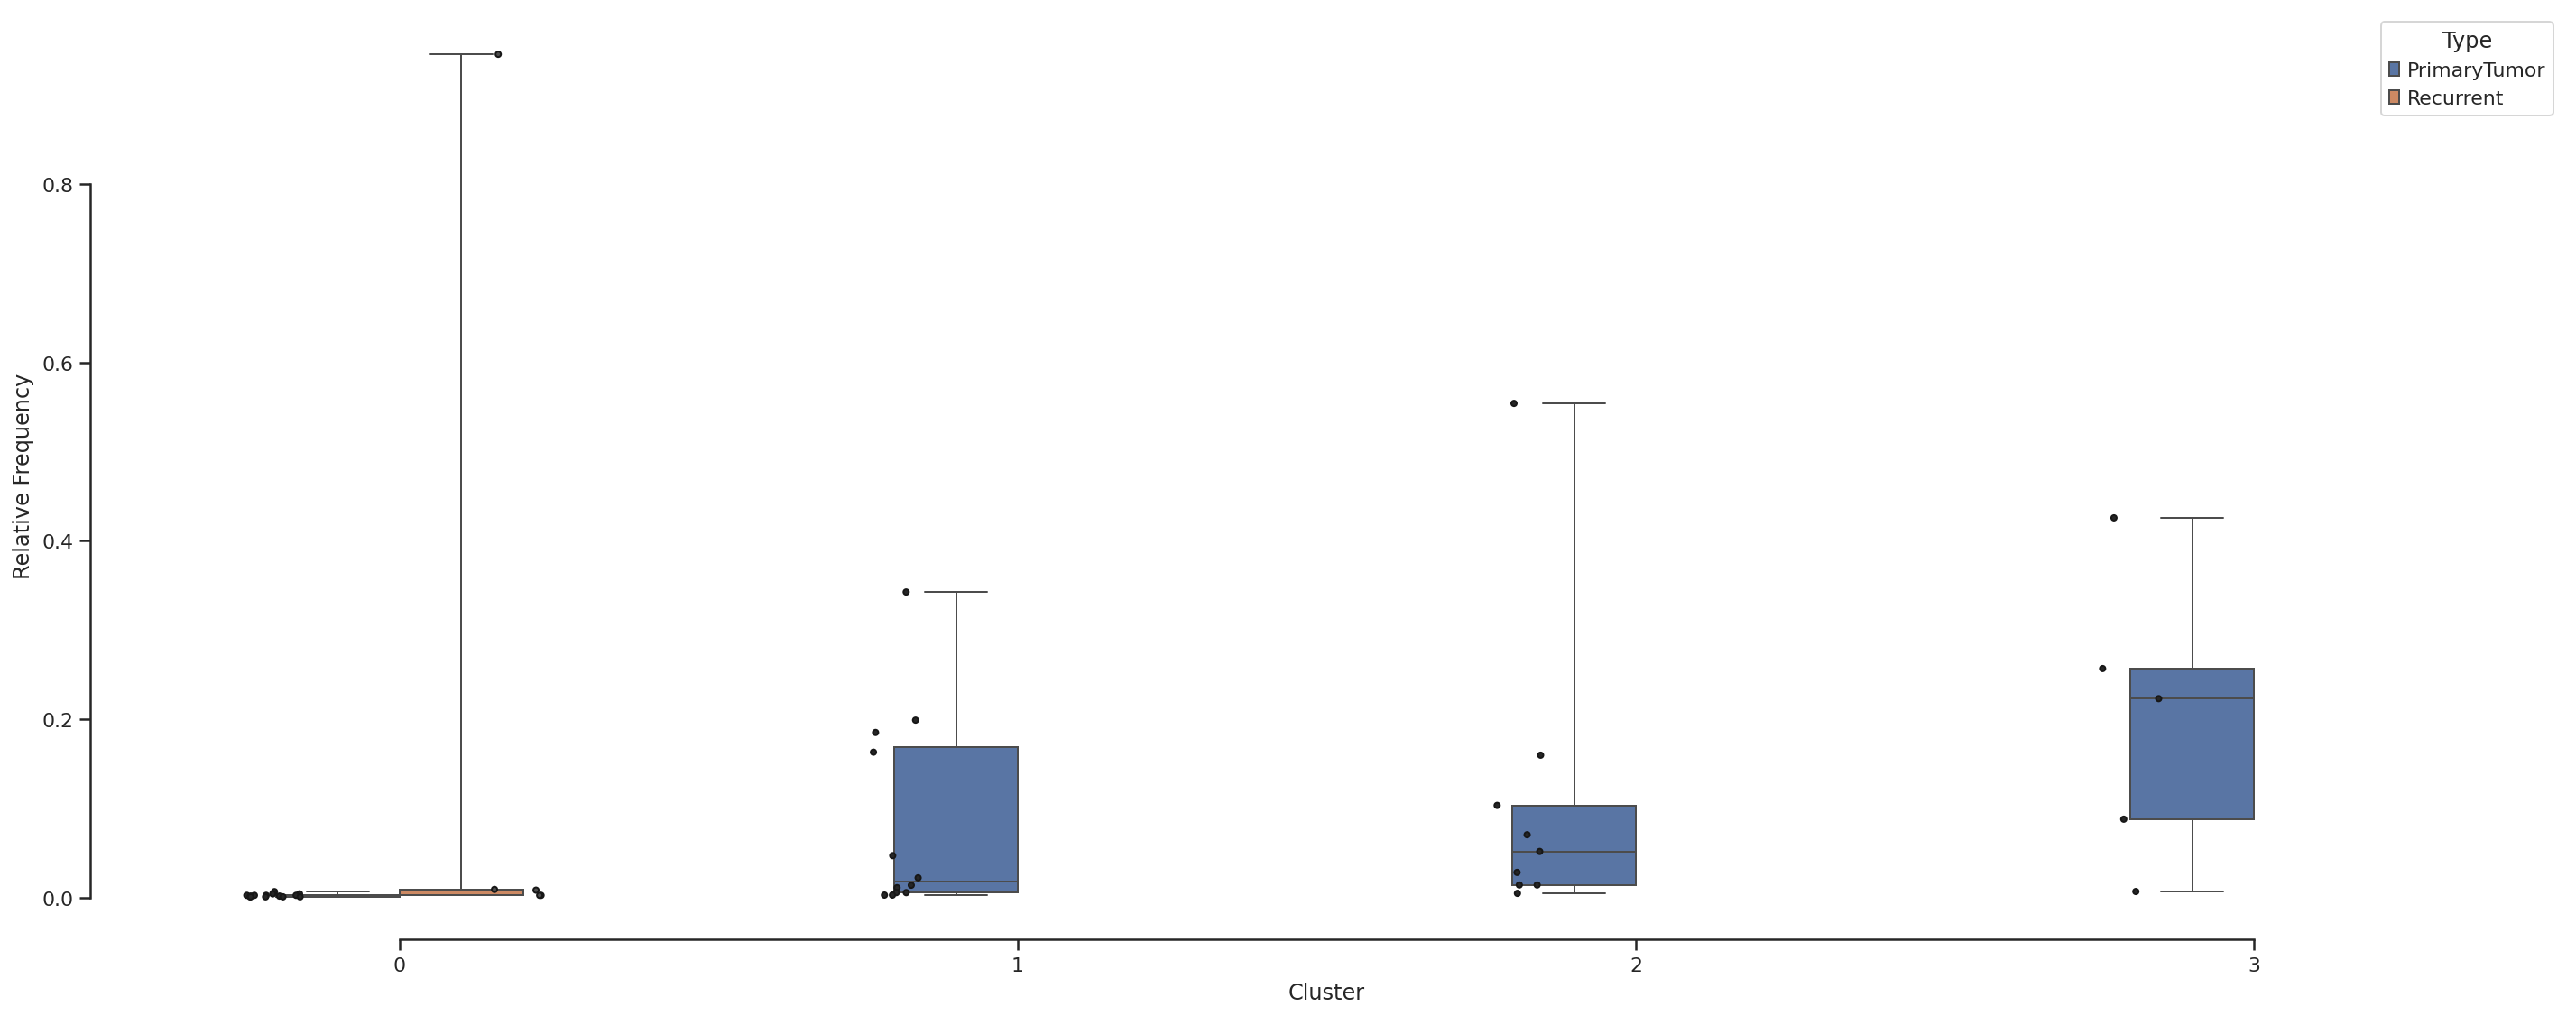

In [41]:
sns.set(rc={'font.family':'Arial', 'font.serif':'Arial'})
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(20, 8))
ax = sns.boxplot(data=df2, x="desc_0.2", y="0",hue="Type",hue_order=['PrimaryTumor','Recurrent'],
                 whis=[0, 100], width=.4,dodge=True)
ax = sns.stripplot(x="desc_0.2", y="0", data=df2,hue="Type",dodge=True,legend=False,hue_order=['PrimaryTumor','Recurrent'],
              size=3, color=".3", linewidth=1)

#add_stat_annotation(ax, data=df2, x="louvain", y="0",hue="Type",
#                                   test='t-test_welch',box_pairs=pairs,
#                                   comparisons_correction=None,
#                                   loc='inside', verbose=2)

ax.xaxis.grid(False)
ax.set(ylabel="Relative Frequency")
ax.set(xlabel="Cluster")
sns.despine(trim=True, left=False)
plt.tight_layout()

## Cohort

In [20]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("desc_0.2")["Cohort"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("desc_0.2")["Cohort"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

## Sample

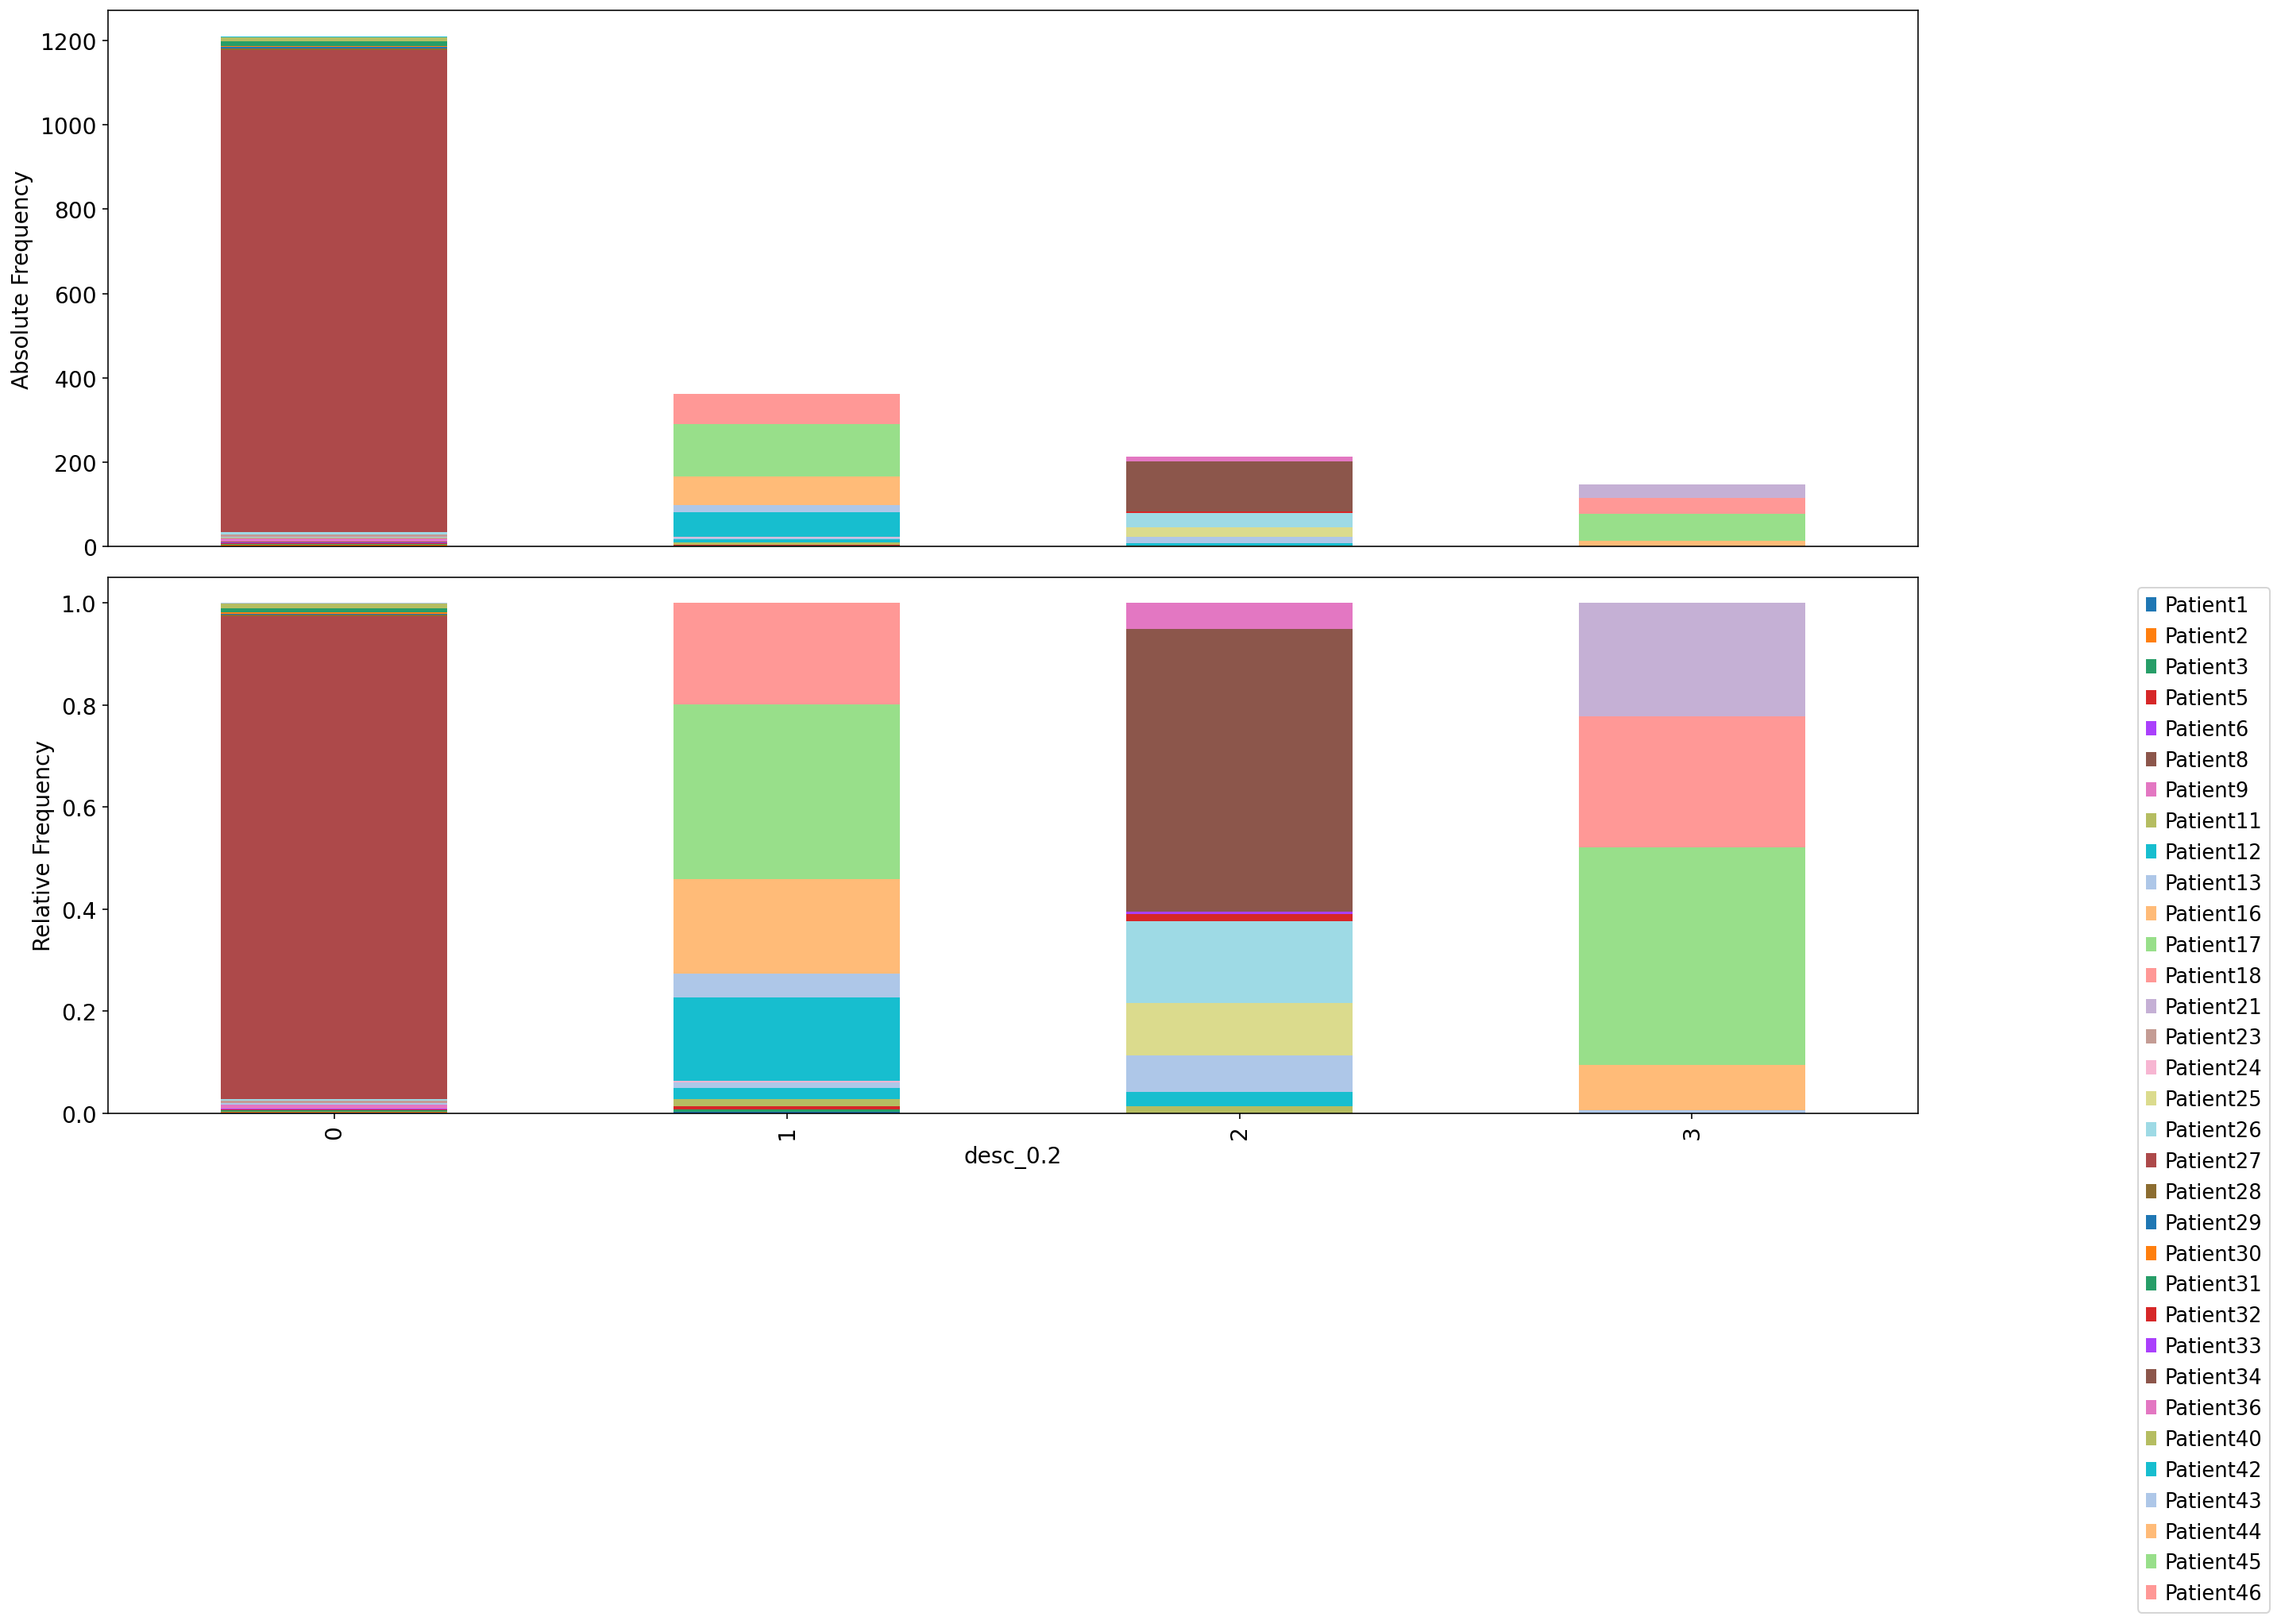

In [21]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("desc_0.2")["Sample"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("desc_0.2")["Sample"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

# Resolution 2 DEGS

In [22]:
sc.tl.rank_genes_groups(adata, 'desc_0.2', method='wilcoxon',pts=0.20)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [23]:
import cytocipher as cc

Added data.uns['desc_0.2_markers']
Added data.obsm['desc_0.2_enrich_scores']


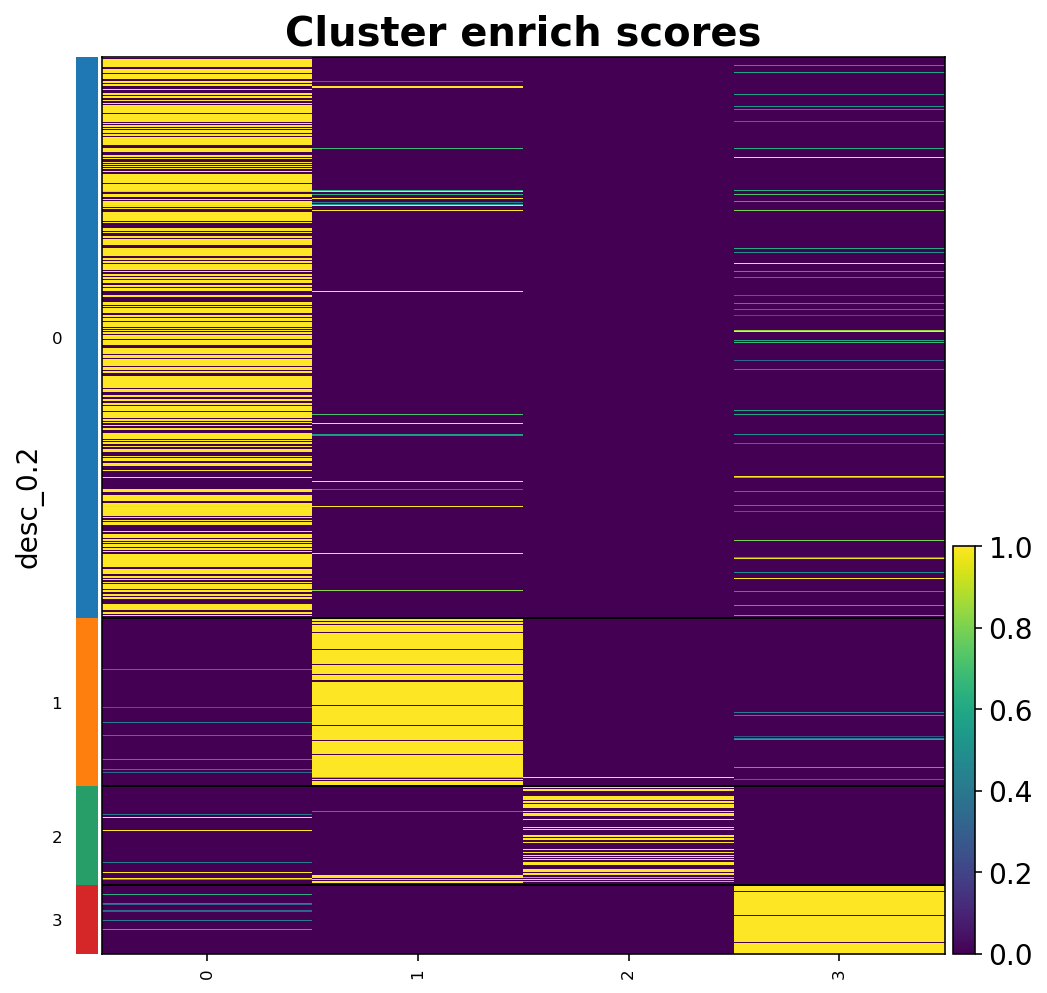

In [24]:
cc.tl.get_markers(adata, 'desc_0.2')
cc.tl.code_enrich(adata, 'desc_0.2')
cc.pl.enrich_heatmap(adata, 'desc_0.2',n_clust_cells=None)

In [25]:
result = adata.uns['rank_genes_groups']

In [26]:
groups = result['names'].dtype.names
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/TregDEGSRes02.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata, group=groups[_]).to_excel(writer, sheet_name=groups[_],index=False)

# Resulution 3

In [27]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.3)]

In [28]:
run_vis(adata)

## Resolution 3 Umap

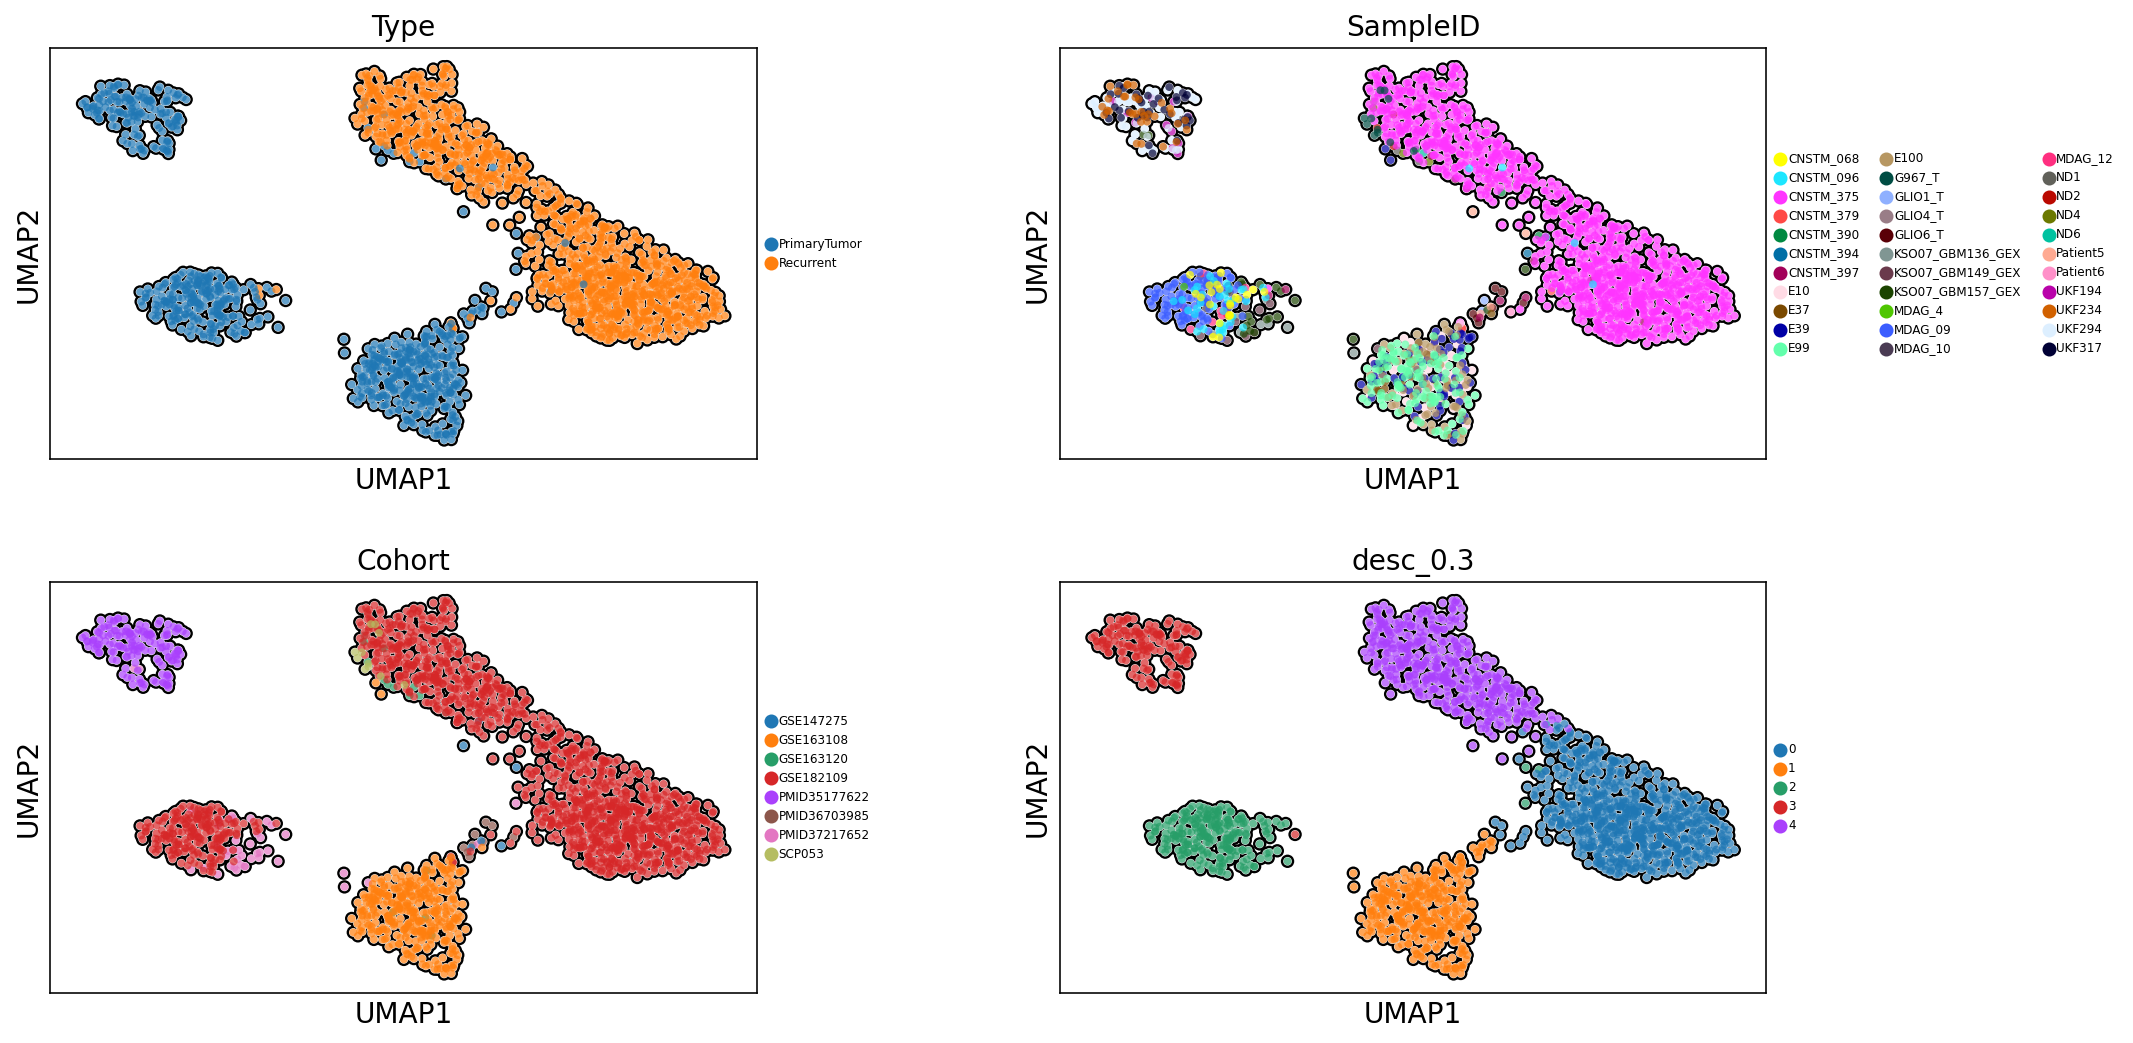

In [29]:
sc.pl.umap(adata, color=['Type','SampleID','Cohort','desc_0.3'],legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

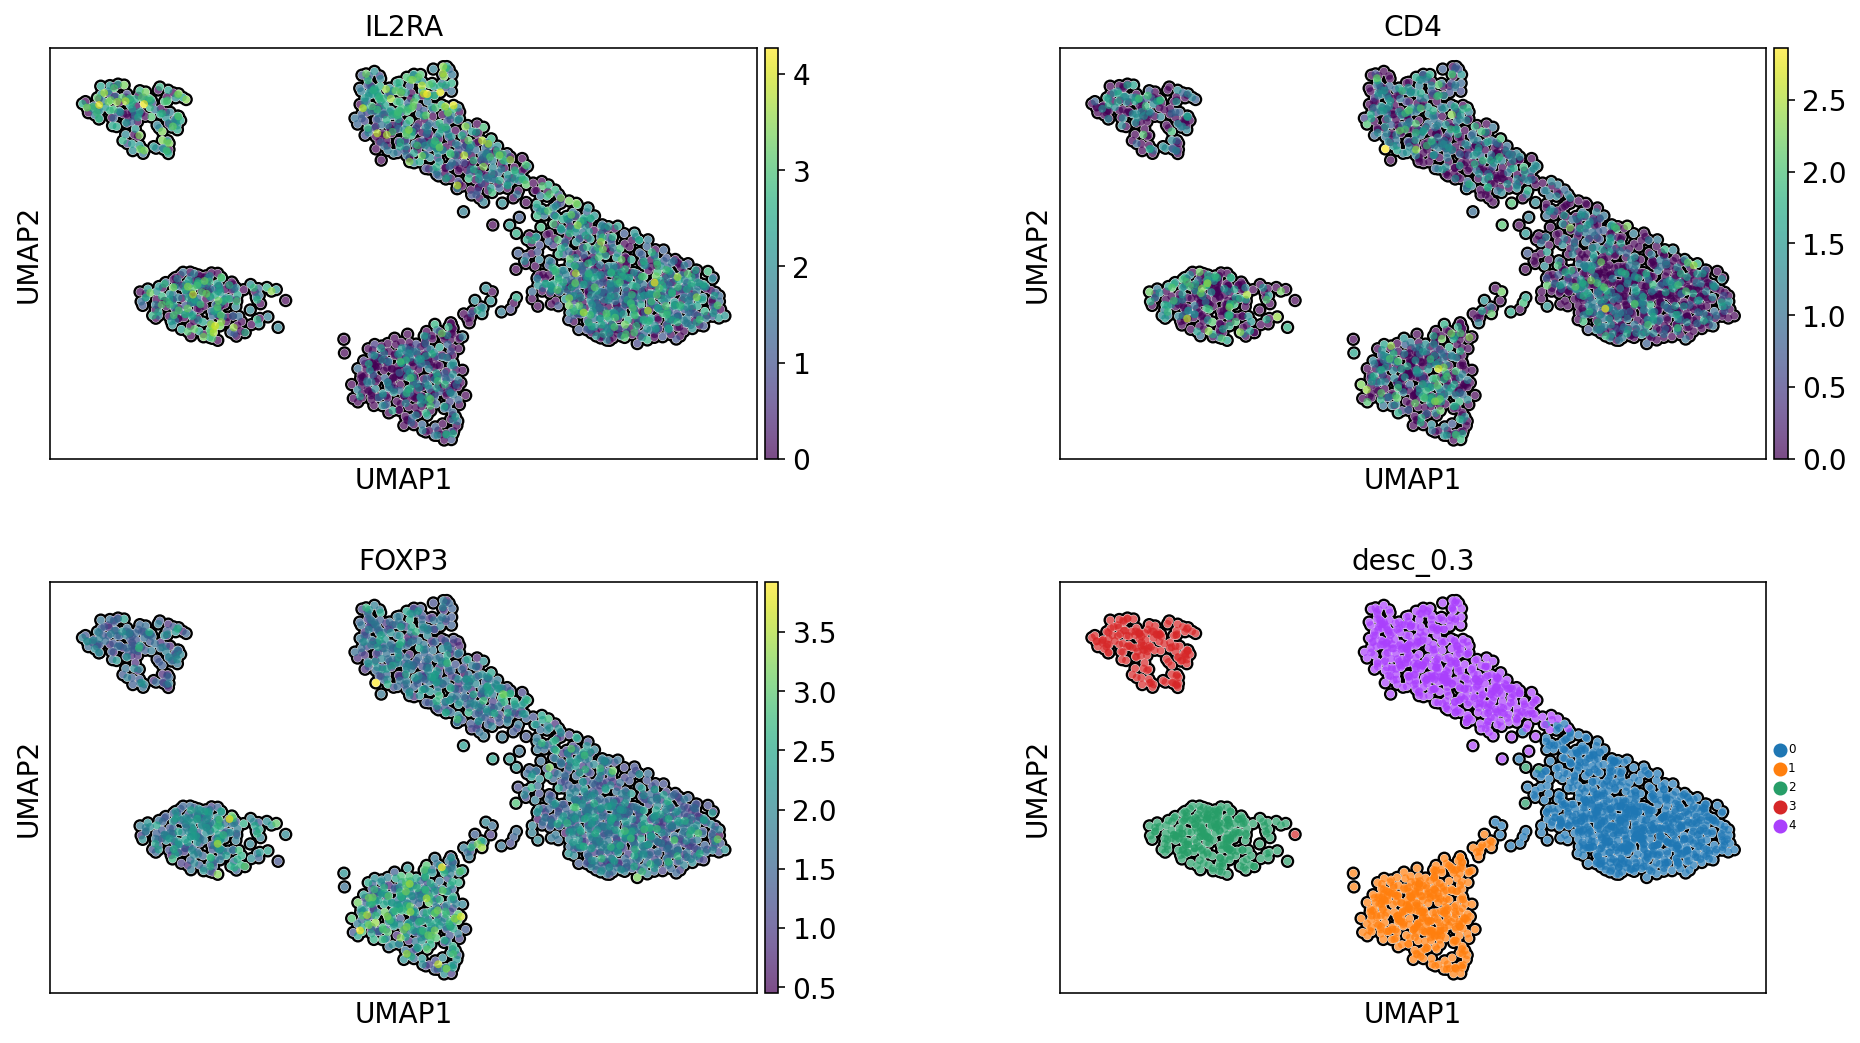

In [30]:
sc.pl.umap(adata, color=["IL2RA", "CD4", "FOXP3","desc_0.3"], legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

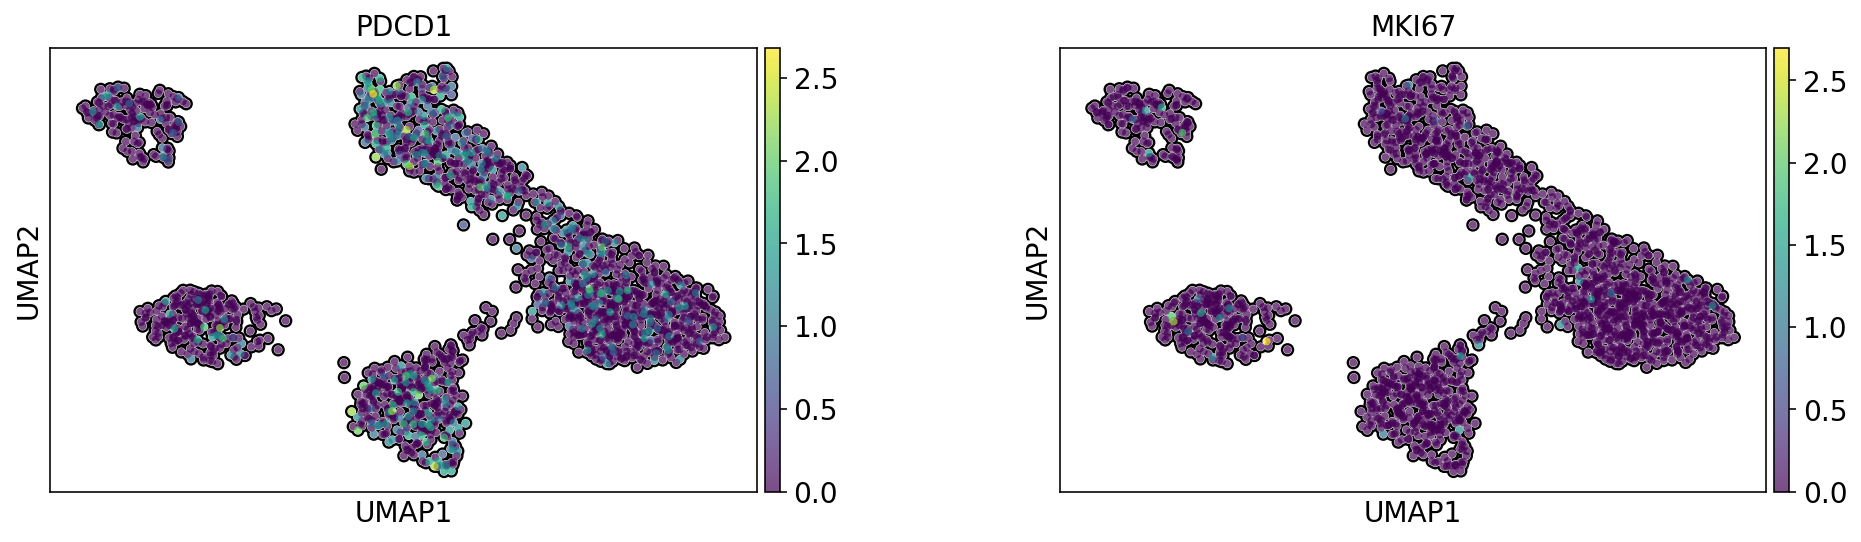

In [31]:
sc.pl.umap(adata, color=["PDCD1","MKI67"], legend_fontsize=6,
           frameon=True, ncols = 2,
                        wspace=.3, hspace=0.3
                        ,add_outline=True)

## Resolution 3 Cluster fraction for Type

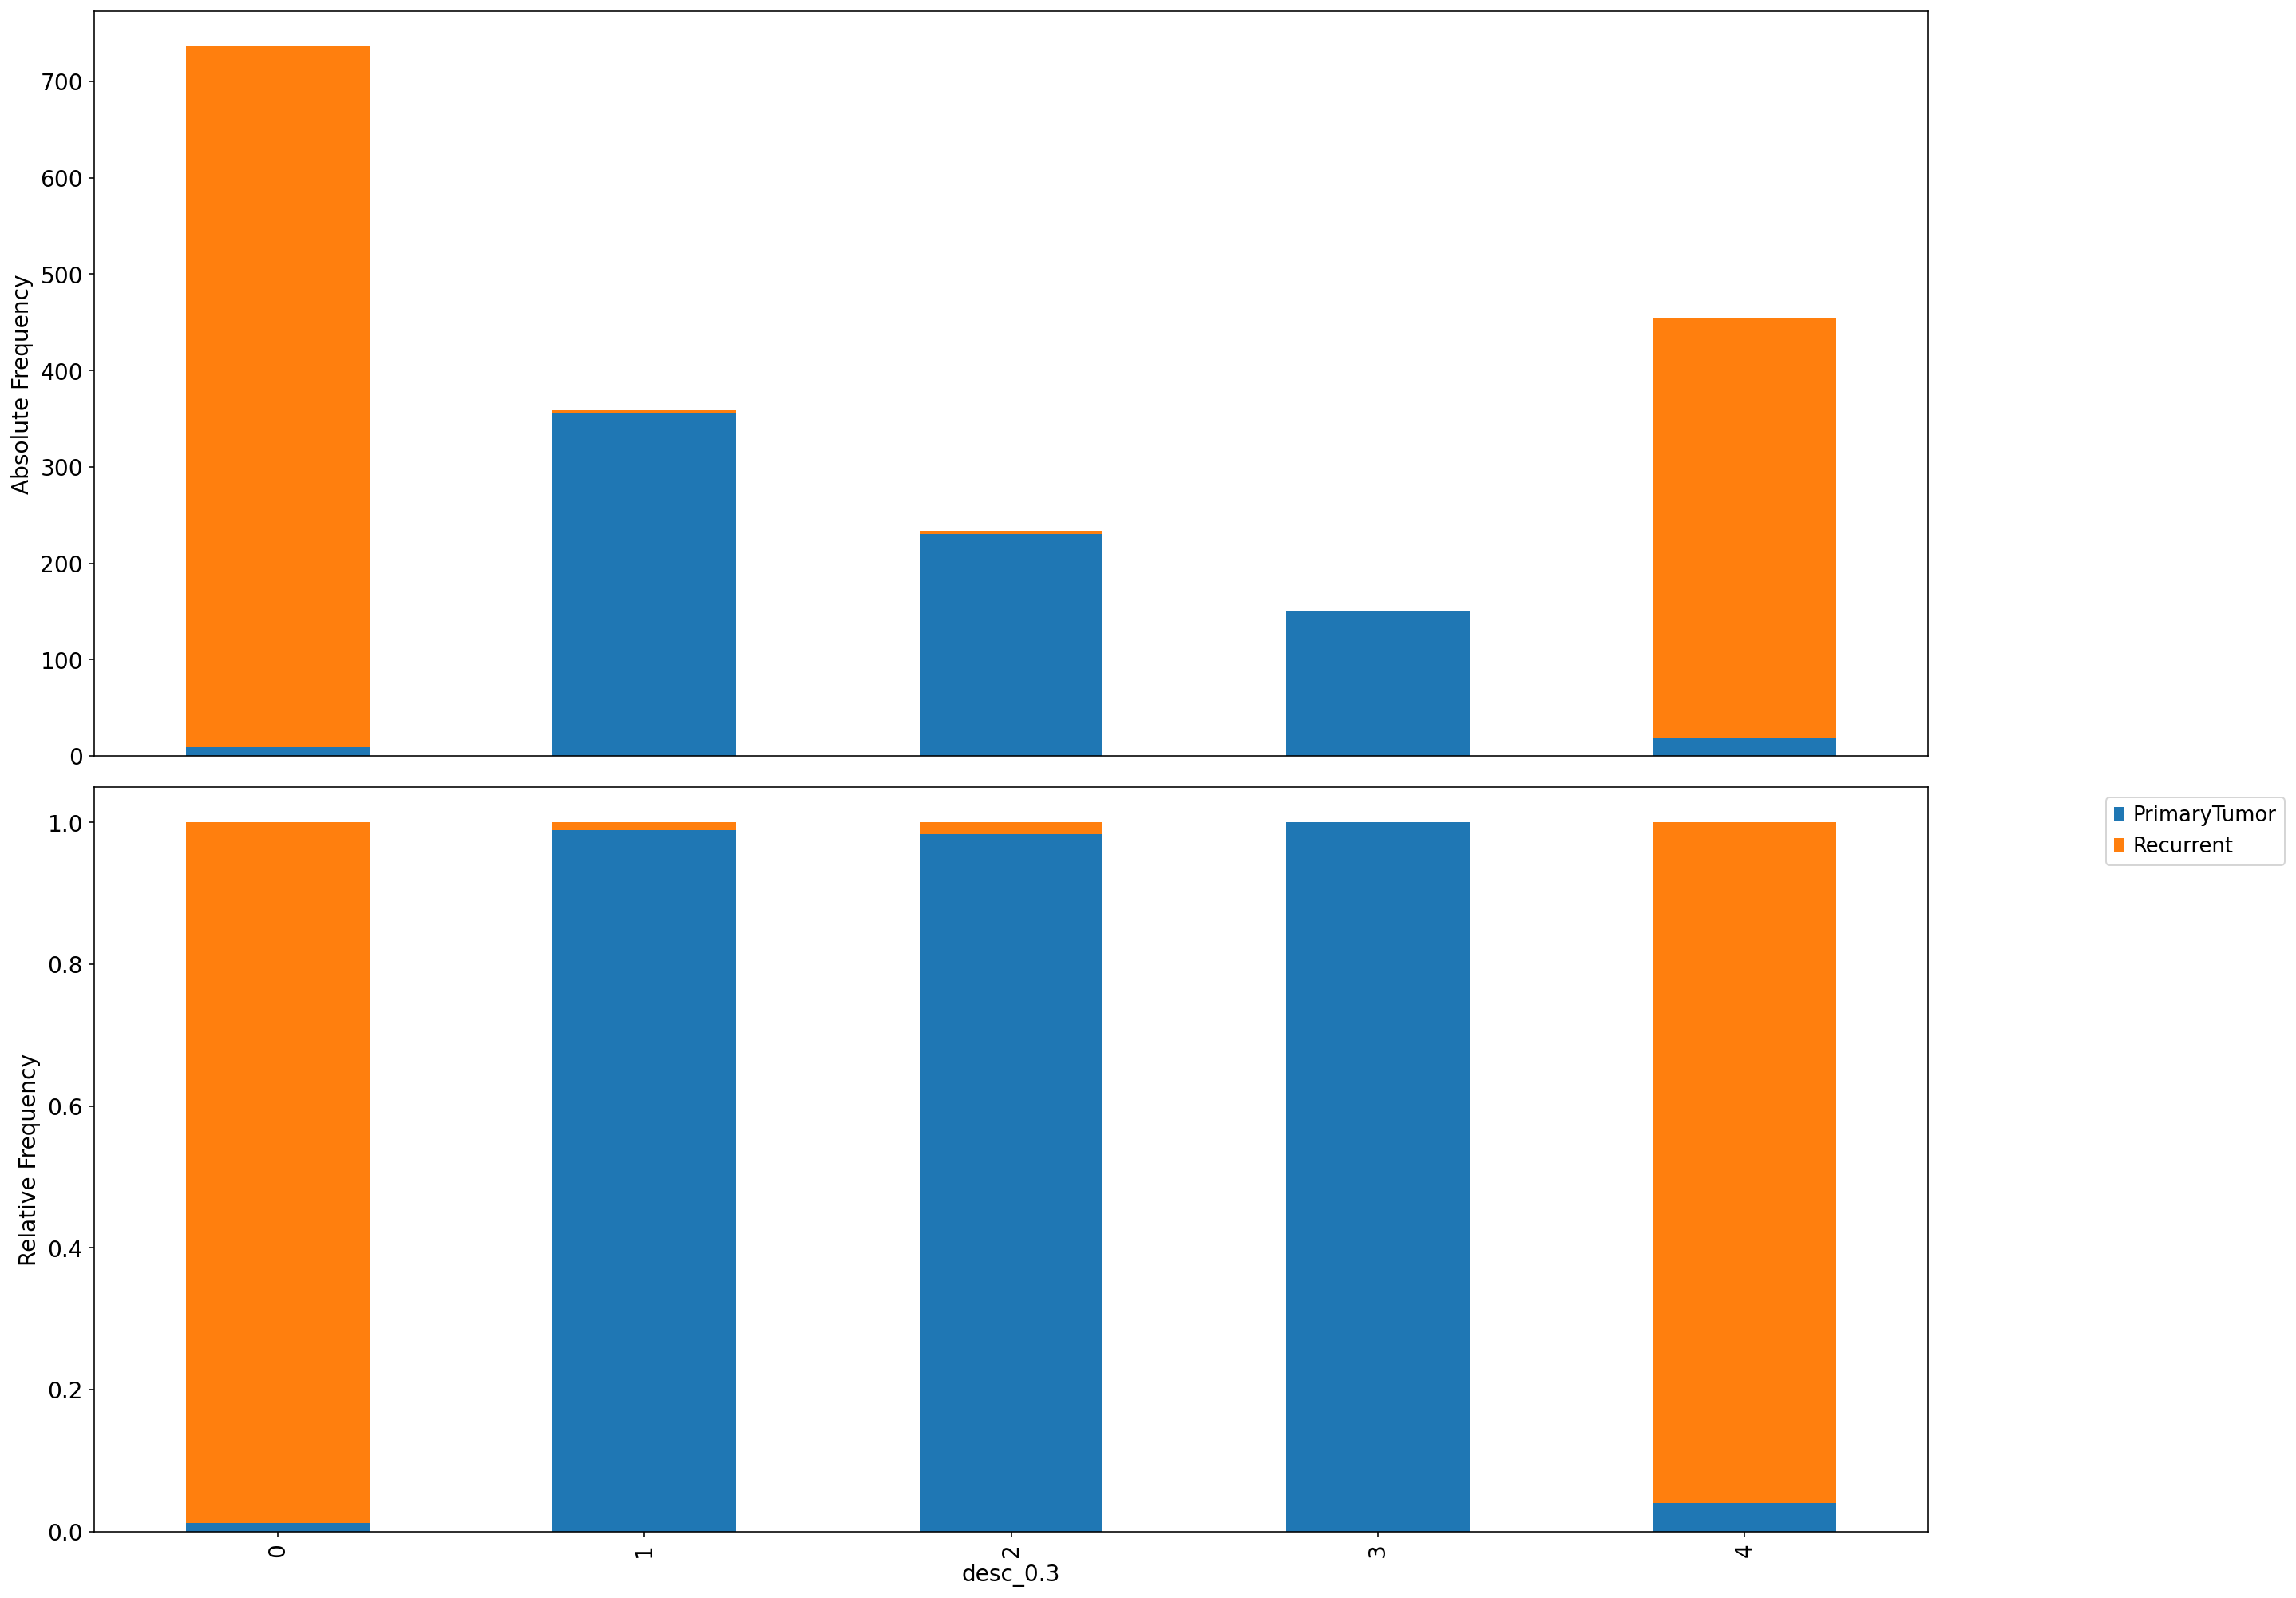

In [32]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("desc_0.3")["Type"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("desc_0.3")["Type"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

In [42]:
df = pd.DataFrame(adata.obs.groupby("desc_0.3")["Type","Sample"].value_counts(normalize=True))
df.to_csv("./test4.csv",sep="\t",header=True,index=True)
df2 = pd.read_csv("./test4.csv",sep="\t",header=0)
df2 = df2.loc[df2['0']>0]

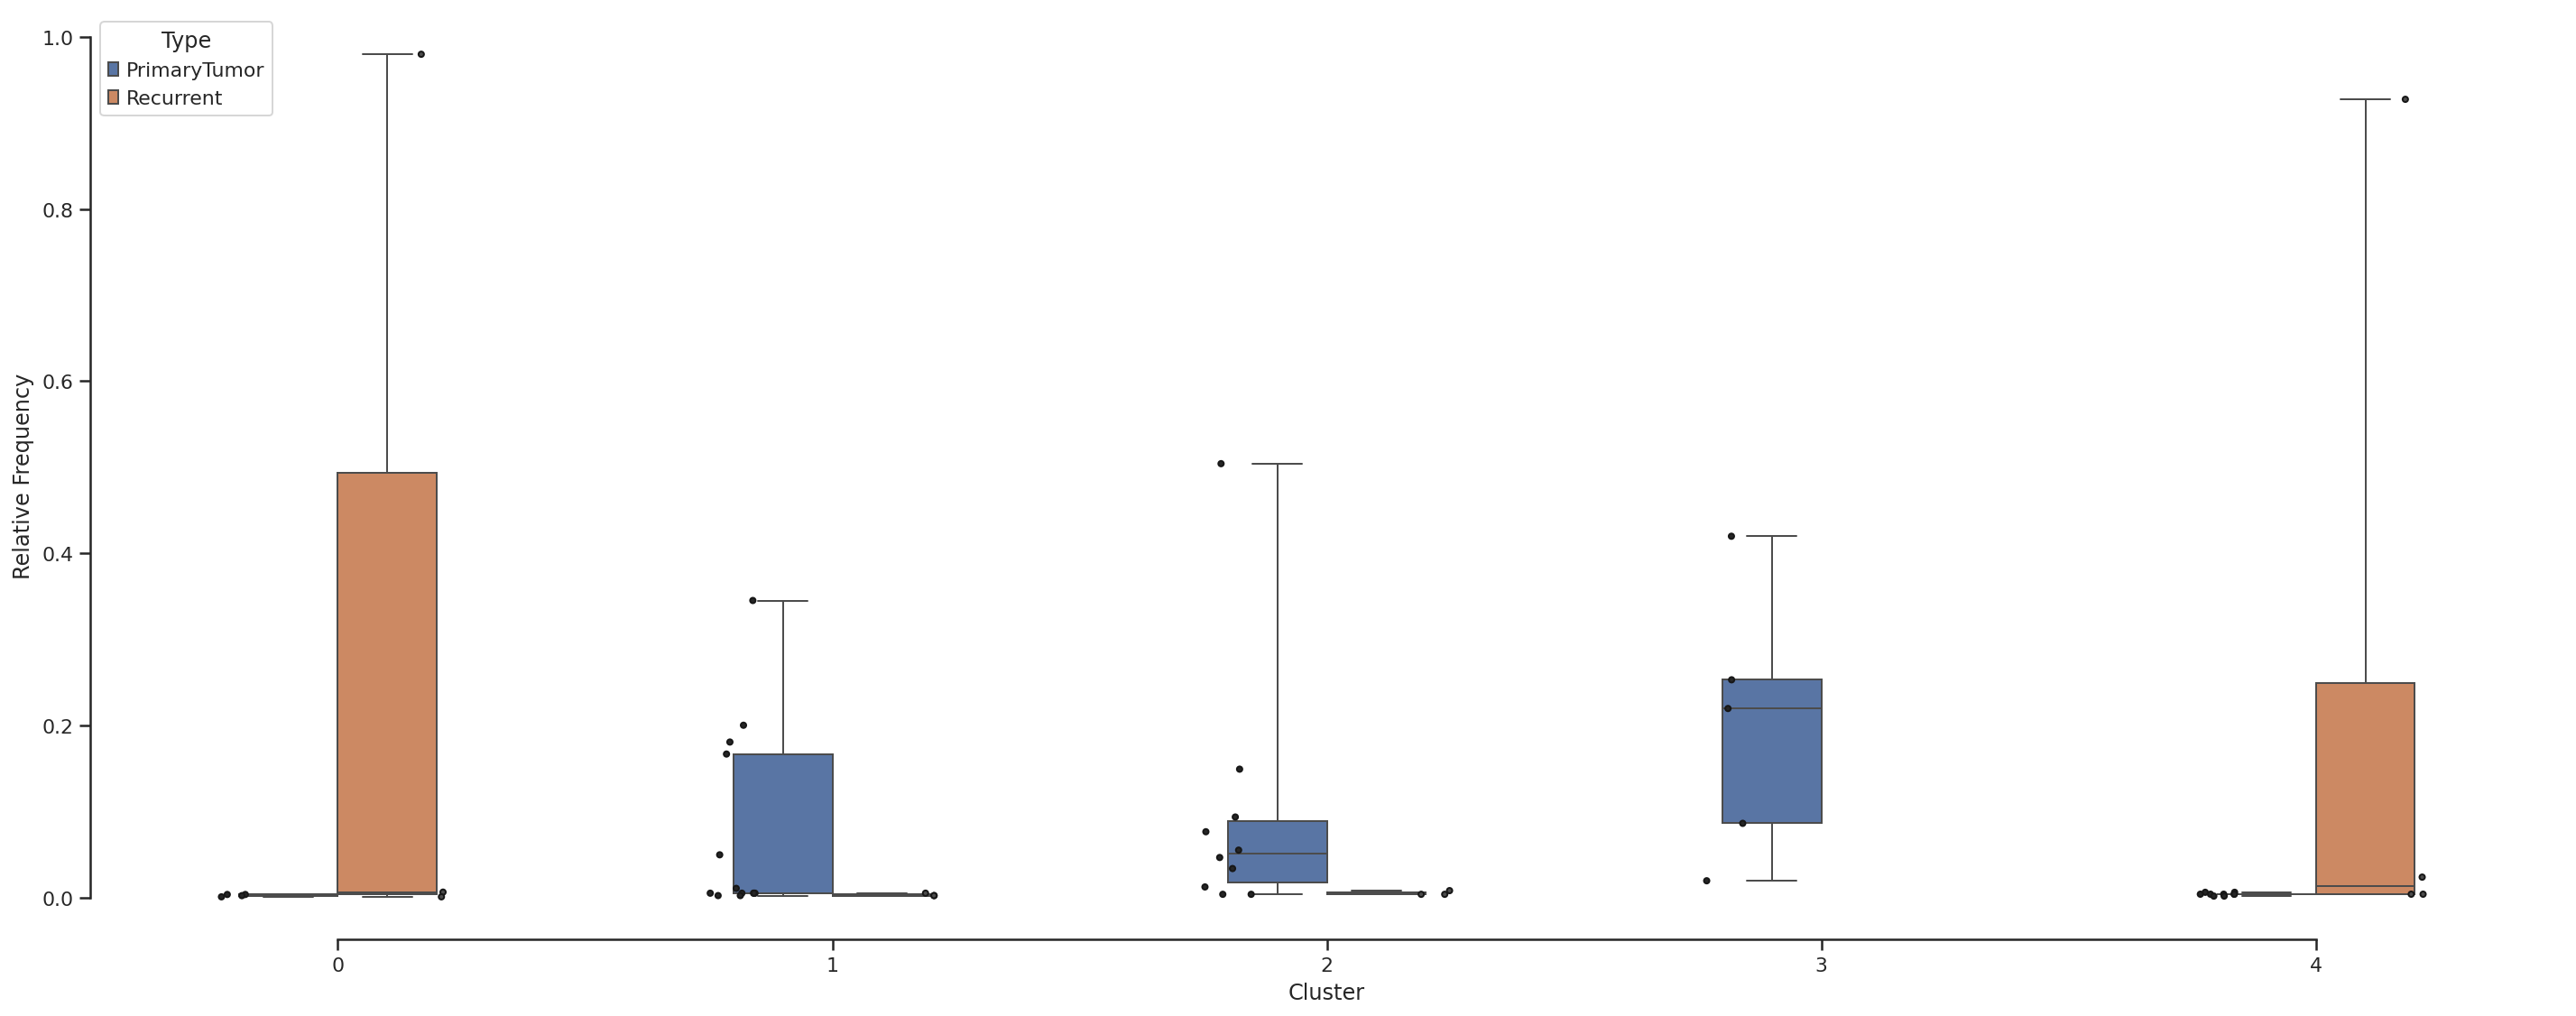

In [43]:
sns.set(rc={'font.family':'Arial', 'font.serif':'Arial'})
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(20, 8))
ax = sns.boxplot(data=df2, x="desc_0.3", y="0",hue="Type",hue_order=['PrimaryTumor','Recurrent'],
                 whis=[0, 100], width=.4,dodge=True)
ax = sns.stripplot(x="desc_0.3", y="0", data=df2,hue="Type",dodge=True,legend=False,hue_order=['PrimaryTumor','Recurrent'],
              size=3, color=".3", linewidth=1)

#add_stat_annotation(ax, data=df2, x="louvain", y="0",hue="Type",
#                                   test='t-test_welch',box_pairs=pairs,
#                                   comparisons_correction=None,
#                                   loc='inside', verbose=2)

ax.xaxis.grid(False)
ax.set(ylabel="Relative Frequency")
ax.set(xlabel="Cluster")
sns.despine(trim=True, left=False)
plt.tight_layout()

## Cohort

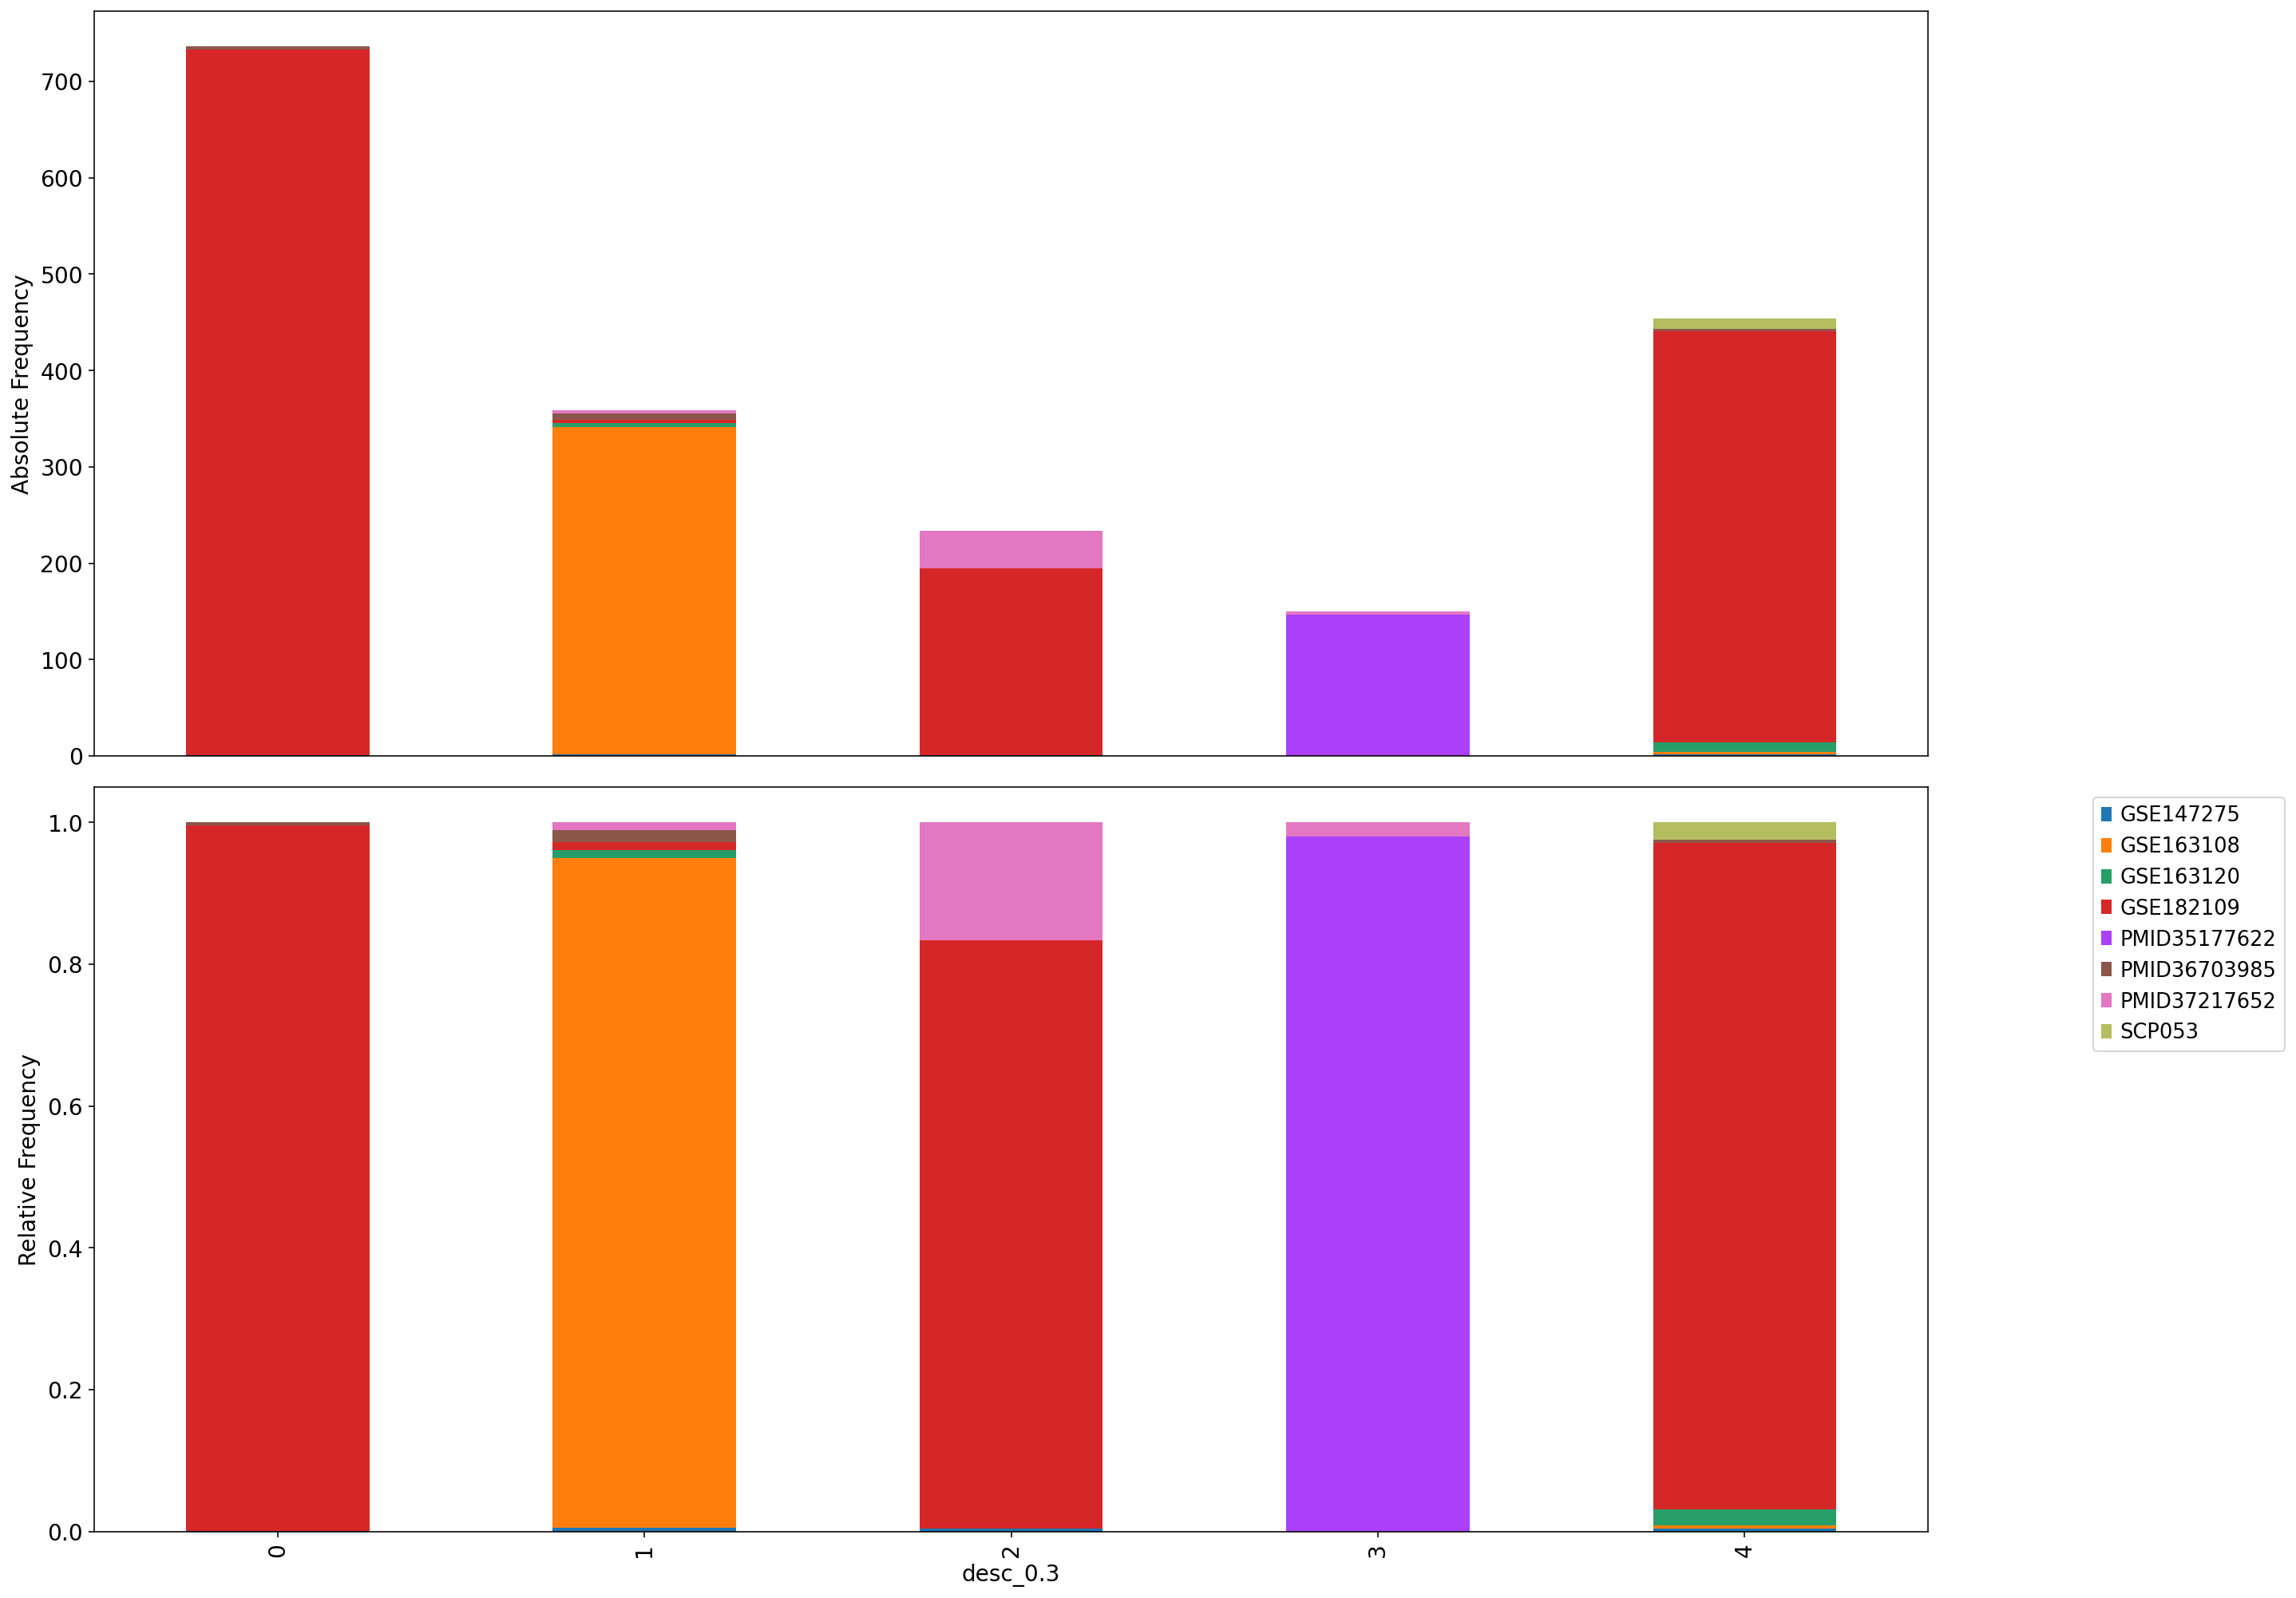

In [34]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("desc_0.3")["Cohort"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("desc_0.3")["Cohort"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

## Sample

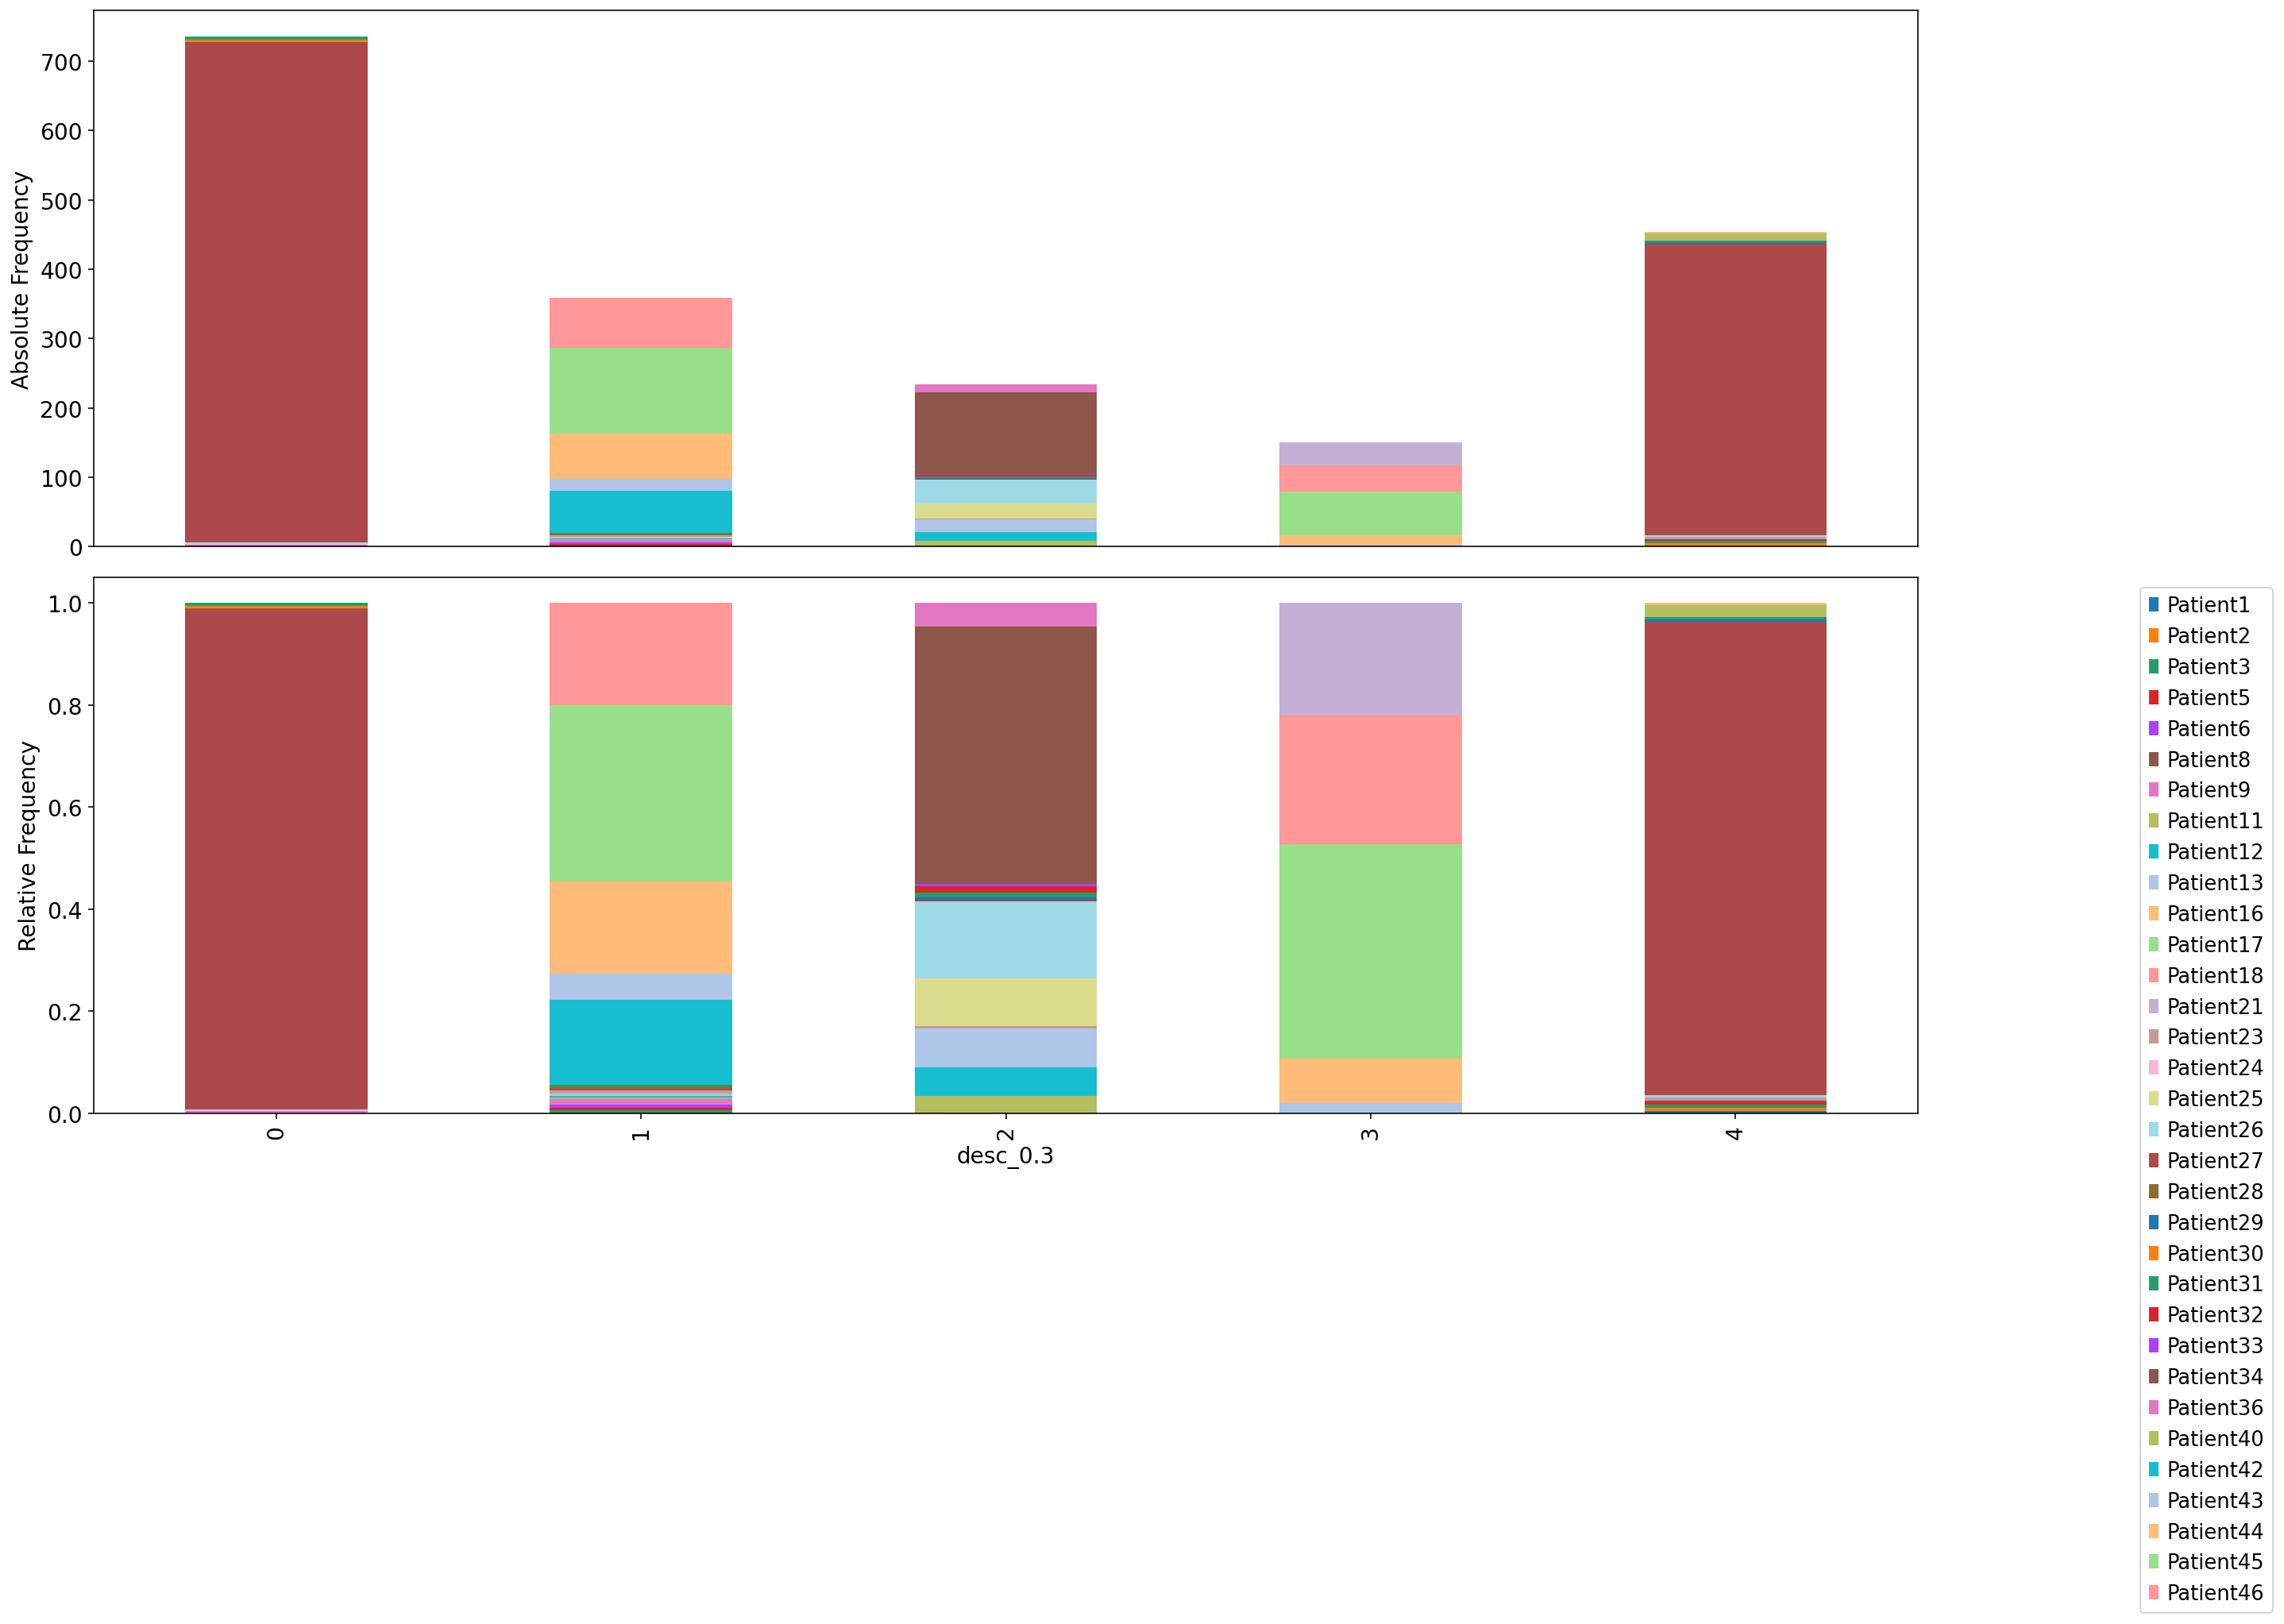

In [35]:
fig, (ax2, ax1) = plt.subplots(2, 1,figsize=(20, 14))
ax1 = adata.obs.groupby("desc_0.3")["Sample"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax2.set_xlabel(" ")
ax2.get_xaxis().set_visible(False)
ax1.set_ylabel("Relative Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))
ax2 = adata.obs.groupby("desc_0.3")["Sample"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Absolute Frequency")
ax2.grid(False)
fig.tight_layout()

## Resolution 3 DEGS

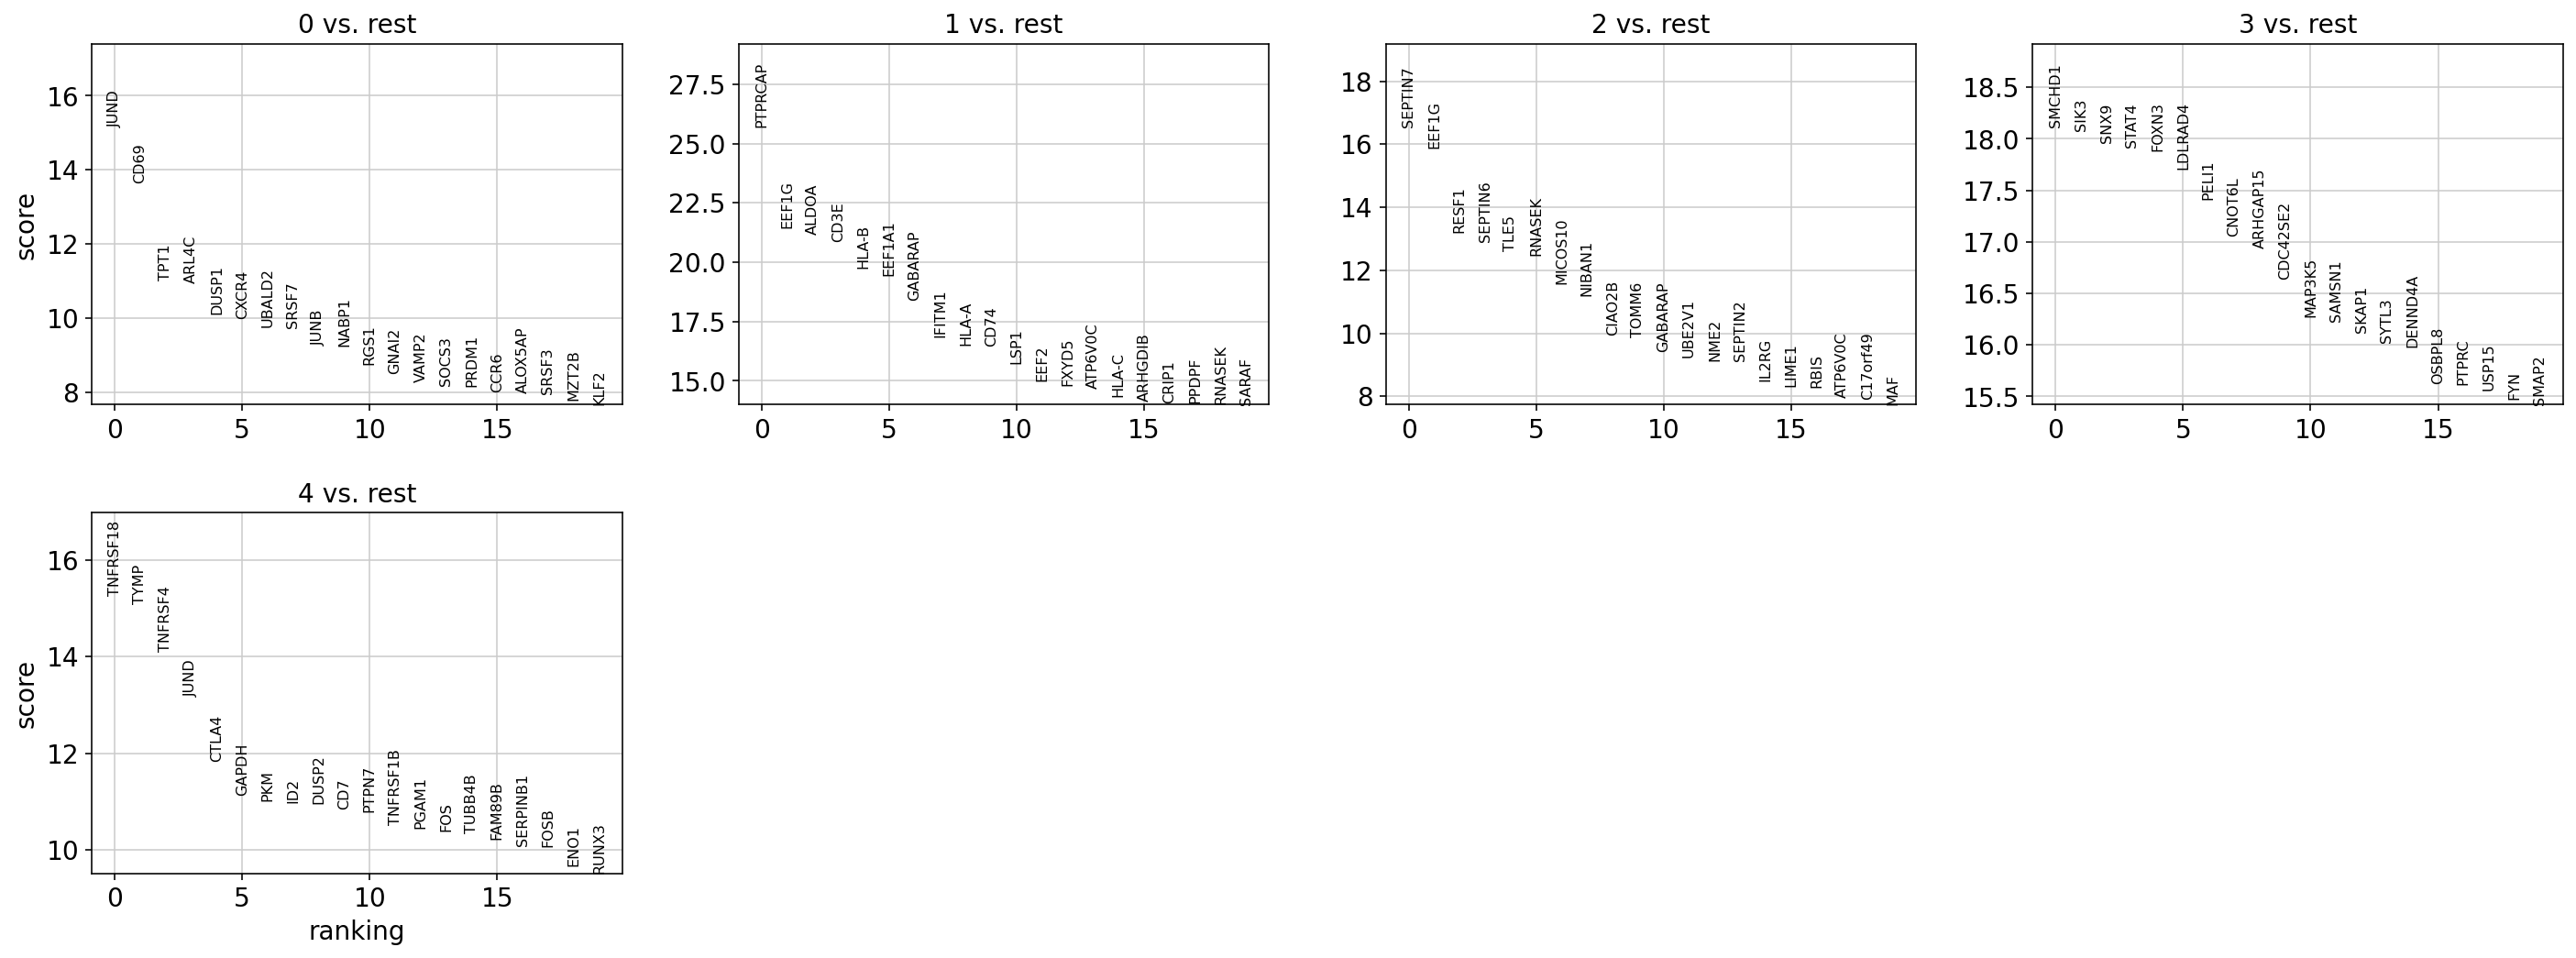

In [36]:
sc.tl.rank_genes_groups(adata, 'desc_0.3', method='wilcoxon',pts=0.20)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

Added data.uns['desc_0.3_markers']
Added data.obsm['desc_0.3_enrich_scores']


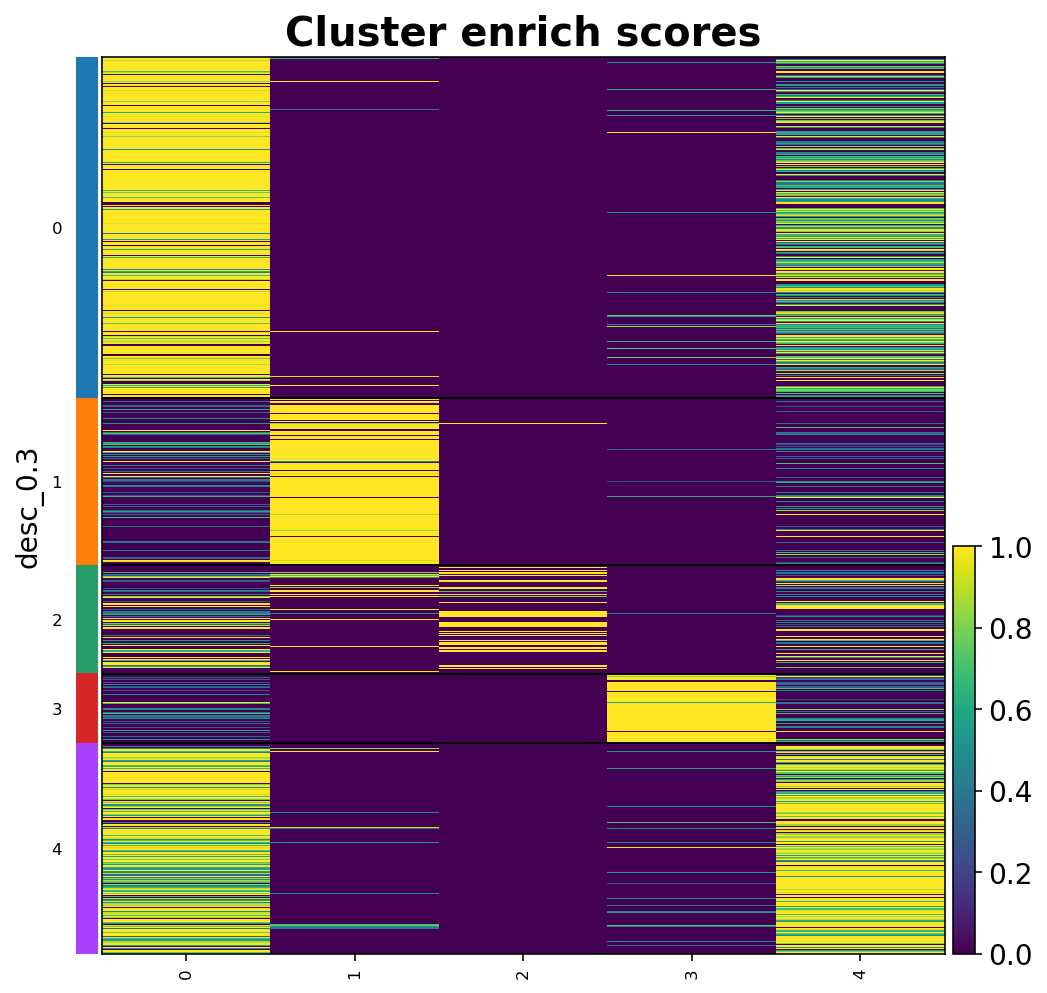

In [37]:
cc.tl.get_markers(adata, 'desc_0.3')
cc.tl.code_enrich(adata, 'desc_0.3')
cc.pl.enrich_heatmap(adata, 'desc_0.3',n_clust_cells=None)

In [38]:
result = adata.uns['rank_genes_groups']

In [39]:
groups = result['names'].dtype.names
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP039/GMB_revisionSept2023/TregDEGSRes03.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata, group=groups[_]).to_excel(writer, sheet_name=groups[_],index=False)